In [45]:
# basic libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# data loading and transforming
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

### Download dataset from torch database

The data can also be augmented here using the transforms variable. Augmentations can include random or uniform crop, brightness, hue, saturation, etc.

Both the training data and testing data are loaded and split here

In [46]:
transforms = transforms.ToTensor()

# Get training and test datasets
train_data = MNIST("../data",
                   train=True,
                   download=True,
                   transform=transforms)
test_data = MNIST("../data",
                  train=False, 
                  transform=transforms)

# Print out some stats about the training and test data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


### Prepare the data

This creates batches of data into a `DataLoader` object. The `batch_size` is a hyperparameter than can be tuned, but generally it is a balance of model performance vs hardware performance. Generally it is increased by a factor of two (keeping note of accuracy) until performance or training time suffers.

In [47]:
# prepare data loaders, set the batch_size
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['zero', 'one', 'two', 'three', 'four', 
           'five', 'six', 'seven', 'eight', 'nine']

### Visualize some training data

This cell iterates over the training dataset, loading a random batch of image/label data, using `dataiter.next()`. It then plots the batch of images and labels in a `batch_size/8 x 8` grid.

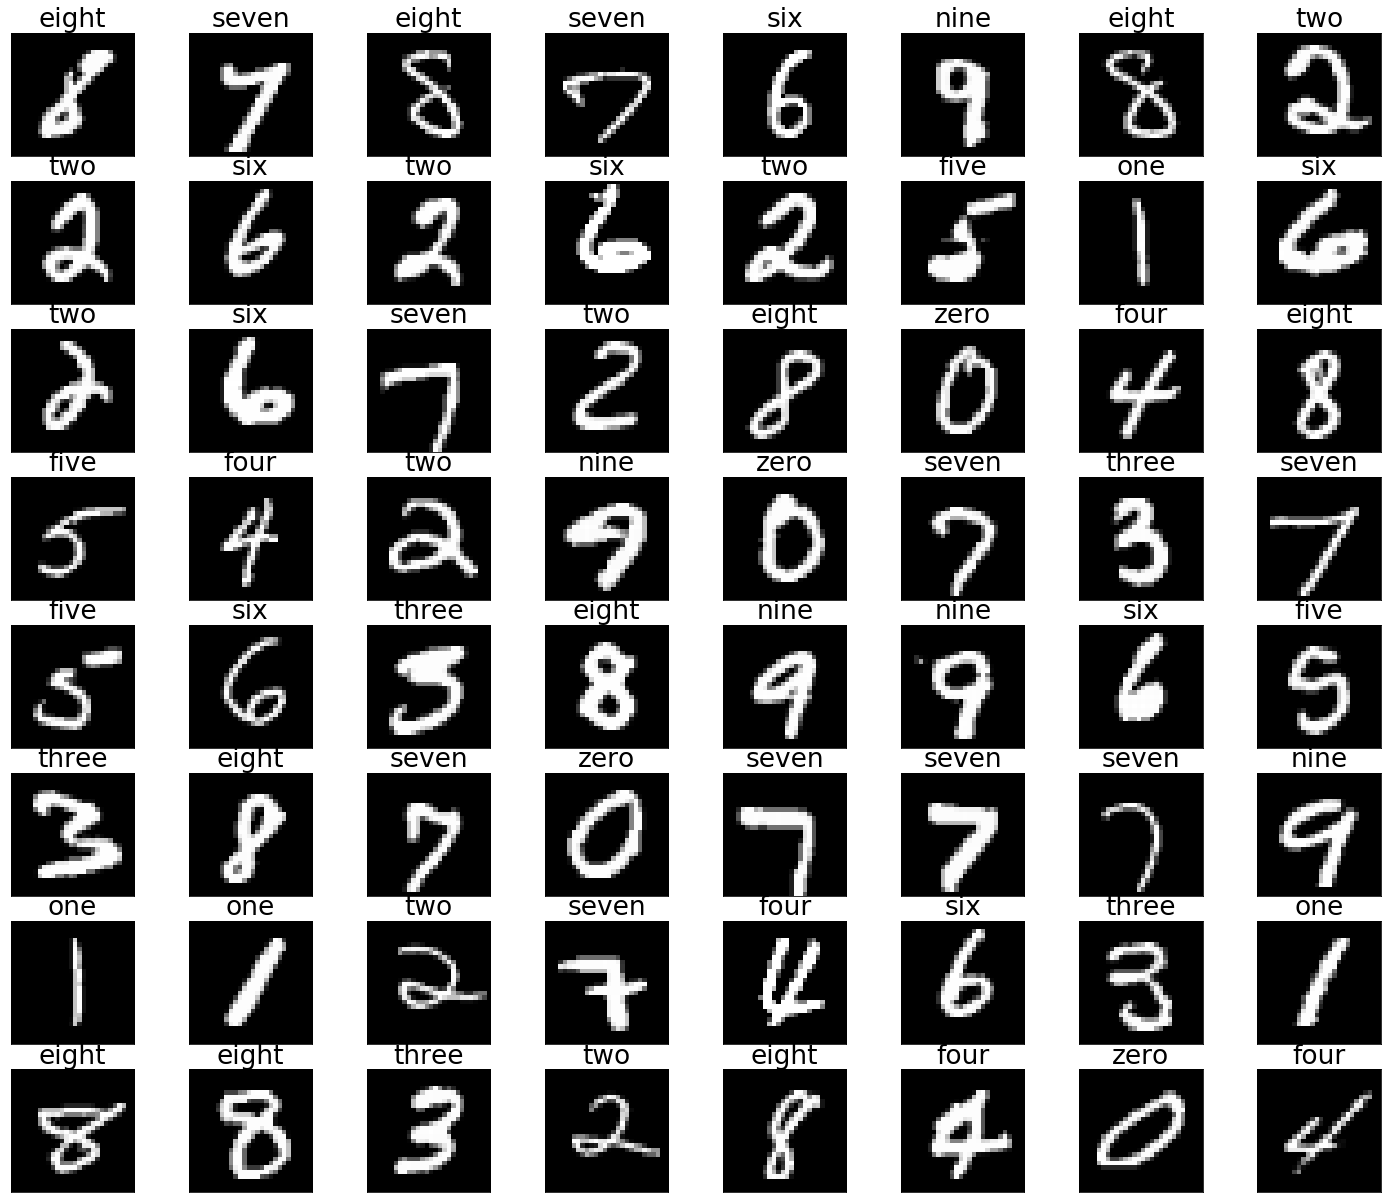

In [48]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, batch_size/3))
plt.rcParams.update({'font.size': 22})
for idx in np.arange(batch_size):
    ax = fig.add_subplot(batch_size/8, 8, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

### Import model

There are a few models in `models.py` generally ranging from least to most complex. The model is loaded using `.cuda()`, which assumes hardware acceleration is supported. This is a flag for the model to expect cuda tensors to be found on the GPU instead of CPU memory.

In [49]:
from models import Net2 as net

# Use CUDA version
net = net().cuda()
print(net)

Net2(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.3)
  (fc1): Linear(in_features=512, out_features=1000, bias=True)
  (dropout4): Dropout(p=0.5)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (dropout5): Dropout(p=0.6)
  (fc3): Line

### Set the optimization parameters

These are the functions that will be used when training the model. `criterion` is the function that is used to calculate loss, and `optimizer` is the function that will determine how the weights are updated according to the loss.

In [50]:
import torch.optim as optim
import torch.nn as nn

# cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.NLLLoss()

# stochastic gradient descent with a small learning rate
optimizer = optim.SGD(net.parameters(), lr=0.001)

### Accuracy before training

This cell is mainly to test our network and make sure it is syntactically correct. The images and labels are obtained from each batch in the test_loader, then they are transferred to GPU memory. The predicted labels are found by passing them through the network, and this value is compared to the actual label.

It is expected that the performance will be bad here since the model is initialized with random weights. If some sort of transfer learning was necessary, it would be beneficial to ensure the model changes do not negatively affect the initialized results.

In [51]:
# Calculate accuracy before training
correct = 0
total = 0

# Iterate through test dataset
for images, labels in test_loader:
    images, labels = images.cuda(), labels.cuda()

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = net(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
# to convert `correct` from a Tensor into a scalar, use .item()
accuracy = 100.0 * correct.item() / total

# print it out!
print('Accuracy before training: ', accuracy)

Accuracy before training:  1.0


### Train function

This function actually controls the adjusting of weights for the training portion. It first sets the network to train to turn on dropout, batch_norm and other parameters that use randomization to avoid overfitting. It keeps track of the running loss for each batch and the loss over time for visualization purposes (can help avoid overfitting). 

For each epoch, every batch is passed through the network. For each batch, the gradient is calculated by performing a forward pass, calculating the loss, performing a backwards pass, and updating the weights accordingly. 

In [52]:
def train(n_epochs):
    net.train()
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 100 == 99:    # print every 100 batches
                avg_loss = running_loss/100
                # record and print the avg loss over the 100 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time

### Start training

This simply calls the above function with the given number of epochs. A state_dict file can be called to load weights from a previous training section by uncommenting the `net.load_state_dict(torch.load(filename))` line. Note, this needs to be the exact same model architecture.

To start, `n_epochs` should be small (<10) to make sure the training function works and the loss is decreasing. If the loss is increasing or negative, there is likely an error in the training function of the model itself. Through each epoch, the loss should decrease, so increasing the numebr of epochs will yield better results and take longer to train. If the number of epochs is too high, the model may be overfitting to the training data. There are techniques to stop the training when the loss appears constant, but that is not implemented here. 

One technique is to use verification data to compare each epoch results to the training data (saving test data for the end) and stopping training when the training data seems to be fitting more closely, and the verification data is getting worse. In reality, every model trains different, and it is often a function of the complexity of the model vs the complexity of the features. 

In [53]:
# define the number of epochs to train for
n_epochs = 1000 # start small to see if your model works, initially

#net.load_state_dict(torch.load('saved_models/<name>.pt'))

# call train and record the loss over time
training_loss = train(n_epochs)

Epoch: 1, Batch: 100, Avg. Loss: 4.452904884815216
Epoch: 1, Batch: 200, Avg. Loss: 3.3944355702400206
Epoch: 1, Batch: 300, Avg. Loss: 2.6595975804328917
Epoch: 1, Batch: 400, Avg. Loss: 2.40438138961792
Epoch: 1, Batch: 500, Avg. Loss: 2.285378303527832
Epoch: 1, Batch: 600, Avg. Loss: 2.182758469581604
Epoch: 1, Batch: 700, Avg. Loss: 2.0946541106700898
Epoch: 1, Batch: 800, Avg. Loss: 2.0295510149002074
Epoch: 1, Batch: 900, Avg. Loss: 1.929506126642227
Epoch: 2, Batch: 100, Avg. Loss: 1.8017039287090302
Epoch: 2, Batch: 200, Avg. Loss: 1.7208531284332276
Epoch: 2, Batch: 300, Avg. Loss: 1.6325329458713531
Epoch: 2, Batch: 400, Avg. Loss: 1.539190912246704
Epoch: 2, Batch: 500, Avg. Loss: 1.4421944475173951
Epoch: 2, Batch: 600, Avg. Loss: 1.3691272616386414
Epoch: 2, Batch: 700, Avg. Loss: 1.278710606098175
Epoch: 2, Batch: 800, Avg. Loss: 1.2198312675952911
Epoch: 2, Batch: 900, Avg. Loss: 1.1386039900779723
Epoch: 3, Batch: 100, Avg. Loss: 1.0742890560626983
Epoch: 3, Batch: 200

Epoch: 18, Batch: 400, Avg. Loss: 0.1864746291190386
Epoch: 18, Batch: 500, Avg. Loss: 0.17618222303688527
Epoch: 18, Batch: 600, Avg. Loss: 0.18813206970691682
Epoch: 18, Batch: 700, Avg. Loss: 0.16496420614421367
Epoch: 18, Batch: 800, Avg. Loss: 0.18336844056844712
Epoch: 18, Batch: 900, Avg. Loss: 0.17272150136530398
Epoch: 19, Batch: 100, Avg. Loss: 0.17566022127866746
Epoch: 19, Batch: 200, Avg. Loss: 0.1893272802978754
Epoch: 19, Batch: 300, Avg. Loss: 0.17954964727163314
Epoch: 19, Batch: 400, Avg. Loss: 0.1721625320613384
Epoch: 19, Batch: 500, Avg. Loss: 0.1761695421487093
Epoch: 19, Batch: 600, Avg. Loss: 0.17001292370259763
Epoch: 19, Batch: 700, Avg. Loss: 0.1858087360858917
Epoch: 19, Batch: 800, Avg. Loss: 0.1732622457295656
Epoch: 19, Batch: 900, Avg. Loss: 0.16919793367385863
Epoch: 20, Batch: 100, Avg. Loss: 0.16712391324341297
Epoch: 20, Batch: 200, Avg. Loss: 0.1614630115032196
Epoch: 20, Batch: 300, Avg. Loss: 0.1876898258179426
Epoch: 20, Batch: 400, Avg. Loss: 0.

Epoch: 35, Batch: 400, Avg. Loss: 0.13103775069117546
Epoch: 35, Batch: 500, Avg. Loss: 0.13081665761768818
Epoch: 35, Batch: 600, Avg. Loss: 0.12897710256278516
Epoch: 35, Batch: 700, Avg. Loss: 0.13226525858044624
Epoch: 35, Batch: 800, Avg. Loss: 0.13663984715938568
Epoch: 35, Batch: 900, Avg. Loss: 0.13361125573515892
Epoch: 36, Batch: 100, Avg. Loss: 0.12189697697758675
Epoch: 36, Batch: 200, Avg. Loss: 0.13141385197639466
Epoch: 36, Batch: 300, Avg. Loss: 0.12843492768704892
Epoch: 36, Batch: 400, Avg. Loss: 0.11375123031437397
Epoch: 36, Batch: 500, Avg. Loss: 0.13705809988081455
Epoch: 36, Batch: 600, Avg. Loss: 0.13111661188304424
Epoch: 36, Batch: 700, Avg. Loss: 0.1486022900789976
Epoch: 36, Batch: 800, Avg. Loss: 0.12838820666074752
Epoch: 36, Batch: 900, Avg. Loss: 0.12321610890328884
Epoch: 37, Batch: 100, Avg. Loss: 0.1361247768253088
Epoch: 37, Batch: 200, Avg. Loss: 0.12874410748481752
Epoch: 37, Batch: 300, Avg. Loss: 0.13993053577840328
Epoch: 37, Batch: 400, Avg. Lo

Epoch: 52, Batch: 400, Avg. Loss: 0.11599929720163345
Epoch: 52, Batch: 500, Avg. Loss: 0.09752122640609741
Epoch: 52, Batch: 600, Avg. Loss: 0.09038237519562245
Epoch: 52, Batch: 700, Avg. Loss: 0.1054922579973936
Epoch: 52, Batch: 800, Avg. Loss: 0.10840094909071922
Epoch: 52, Batch: 900, Avg. Loss: 0.11567365877330303
Epoch: 53, Batch: 100, Avg. Loss: 0.11148622982203961
Epoch: 53, Batch: 200, Avg. Loss: 0.10556715726852417
Epoch: 53, Batch: 300, Avg. Loss: 0.09587929971516132
Epoch: 53, Batch: 400, Avg. Loss: 0.12363133490085602
Epoch: 53, Batch: 500, Avg. Loss: 0.10403505489230155
Epoch: 53, Batch: 600, Avg. Loss: 0.10433159790933132
Epoch: 53, Batch: 700, Avg. Loss: 0.10960706524550914
Epoch: 53, Batch: 800, Avg. Loss: 0.10538345634937286
Epoch: 53, Batch: 900, Avg. Loss: 0.10653051927685737
Epoch: 54, Batch: 100, Avg. Loss: 0.10644967287778855
Epoch: 54, Batch: 200, Avg. Loss: 0.10561265476047993
Epoch: 54, Batch: 300, Avg. Loss: 0.10764876939356327
Epoch: 54, Batch: 400, Avg. L

Epoch: 69, Batch: 300, Avg. Loss: 0.09430132851004601
Epoch: 69, Batch: 400, Avg. Loss: 0.0965896037966013
Epoch: 69, Batch: 500, Avg. Loss: 0.09290353938937188
Epoch: 69, Batch: 600, Avg. Loss: 0.11124850541353226
Epoch: 69, Batch: 700, Avg. Loss: 0.09433628745377064
Epoch: 69, Batch: 800, Avg. Loss: 0.08261031292378902
Epoch: 69, Batch: 900, Avg. Loss: 0.09100077465176583
Epoch: 70, Batch: 100, Avg. Loss: 0.0912116875499487
Epoch: 70, Batch: 200, Avg. Loss: 0.09183600723743439
Epoch: 70, Batch: 300, Avg. Loss: 0.08217784464359283
Epoch: 70, Batch: 400, Avg. Loss: 0.10397103480994702
Epoch: 70, Batch: 500, Avg. Loss: 0.08067858465015888
Epoch: 70, Batch: 600, Avg. Loss: 0.10307347171008586
Epoch: 70, Batch: 700, Avg. Loss: 0.08933373242616653
Epoch: 70, Batch: 800, Avg. Loss: 0.10130013704299927
Epoch: 70, Batch: 900, Avg. Loss: 0.09008154839277267
Epoch: 71, Batch: 100, Avg. Loss: 0.08379532724618911
Epoch: 71, Batch: 200, Avg. Loss: 0.09198853775858878
Epoch: 71, Batch: 300, Avg. Lo

Epoch: 86, Batch: 300, Avg. Loss: 0.08686496429145336
Epoch: 86, Batch: 400, Avg. Loss: 0.07939108066260815
Epoch: 86, Batch: 500, Avg. Loss: 0.08184866778552533
Epoch: 86, Batch: 600, Avg. Loss: 0.09023882023990154
Epoch: 86, Batch: 700, Avg. Loss: 0.08042468510568142
Epoch: 86, Batch: 800, Avg. Loss: 0.0901332774013281
Epoch: 86, Batch: 900, Avg. Loss: 0.08729609198868275
Epoch: 87, Batch: 100, Avg. Loss: 0.090861132517457
Epoch: 87, Batch: 200, Avg. Loss: 0.08258832819759845
Epoch: 87, Batch: 300, Avg. Loss: 0.07971448831260204
Epoch: 87, Batch: 400, Avg. Loss: 0.08434415318071842
Epoch: 87, Batch: 500, Avg. Loss: 0.08906706631183624
Epoch: 87, Batch: 600, Avg. Loss: 0.07619240760803223
Epoch: 87, Batch: 700, Avg. Loss: 0.08897438123822213
Epoch: 87, Batch: 800, Avg. Loss: 0.08686970263719558
Epoch: 87, Batch: 900, Avg. Loss: 0.08268445990979671
Epoch: 88, Batch: 100, Avg. Loss: 0.07957580752670765
Epoch: 88, Batch: 200, Avg. Loss: 0.08696162894368172
Epoch: 88, Batch: 300, Avg. Los

Epoch: 103, Batch: 200, Avg. Loss: 0.07682436674833298
Epoch: 103, Batch: 300, Avg. Loss: 0.08629803583025933
Epoch: 103, Batch: 400, Avg. Loss: 0.07072281911969185
Epoch: 103, Batch: 500, Avg. Loss: 0.07915310770273208
Epoch: 103, Batch: 600, Avg. Loss: 0.08290607042610645
Epoch: 103, Batch: 700, Avg. Loss: 0.07813271686434746
Epoch: 103, Batch: 800, Avg. Loss: 0.07658857315778732
Epoch: 103, Batch: 900, Avg. Loss: 0.07540241628885269
Epoch: 104, Batch: 100, Avg. Loss: 0.08395576551556587
Epoch: 104, Batch: 200, Avg. Loss: 0.0740804585069418
Epoch: 104, Batch: 300, Avg. Loss: 0.07644367791712284
Epoch: 104, Batch: 400, Avg. Loss: 0.07574278943240642
Epoch: 104, Batch: 500, Avg. Loss: 0.07588396742939948
Epoch: 104, Batch: 600, Avg. Loss: 0.07471557475626468
Epoch: 104, Batch: 700, Avg. Loss: 0.07189608909189701
Epoch: 104, Batch: 800, Avg. Loss: 0.08148979678750039
Epoch: 104, Batch: 900, Avg. Loss: 0.07536472007632256
Epoch: 105, Batch: 100, Avg. Loss: 0.07365230955183506
Epoch: 105,

Epoch: 119, Batch: 800, Avg. Loss: 0.06725186362862587
Epoch: 119, Batch: 900, Avg. Loss: 0.07036679781973362
Epoch: 120, Batch: 100, Avg. Loss: 0.06347520589828491
Epoch: 120, Batch: 200, Avg. Loss: 0.07426285333931446
Epoch: 120, Batch: 300, Avg. Loss: 0.06632909417152405
Epoch: 120, Batch: 400, Avg. Loss: 0.0783884820342064
Epoch: 120, Batch: 500, Avg. Loss: 0.07442217491567135
Epoch: 120, Batch: 600, Avg. Loss: 0.07467479825019836
Epoch: 120, Batch: 700, Avg. Loss: 0.07491760410368442
Epoch: 120, Batch: 800, Avg. Loss: 0.07252309702336789
Epoch: 120, Batch: 900, Avg. Loss: 0.06722900390625
Epoch: 121, Batch: 100, Avg. Loss: 0.0784424439817667
Epoch: 121, Batch: 200, Avg. Loss: 0.06825517579913139
Epoch: 121, Batch: 300, Avg. Loss: 0.06598586022853851
Epoch: 121, Batch: 400, Avg. Loss: 0.07673633560538291
Epoch: 121, Batch: 500, Avg. Loss: 0.06168938964605331
Epoch: 121, Batch: 600, Avg. Loss: 0.06685384973883629
Epoch: 121, Batch: 700, Avg. Loss: 0.07229442790150642
Epoch: 121, Bat

Epoch: 136, Batch: 500, Avg. Loss: 0.0752901667356491
Epoch: 136, Batch: 600, Avg. Loss: 0.06310301728546619
Epoch: 136, Batch: 700, Avg. Loss: 0.06653887890279293
Epoch: 136, Batch: 800, Avg. Loss: 0.07363317415118217
Epoch: 136, Batch: 900, Avg. Loss: 0.06184304941445589
Epoch: 137, Batch: 100, Avg. Loss: 0.06889468163251877
Epoch: 137, Batch: 200, Avg. Loss: 0.07244569204747676
Epoch: 137, Batch: 300, Avg. Loss: 0.0655221989005804
Epoch: 137, Batch: 400, Avg. Loss: 0.06582921624183655
Epoch: 137, Batch: 500, Avg. Loss: 0.06395795904099941
Epoch: 137, Batch: 600, Avg. Loss: 0.06892592951655388
Epoch: 137, Batch: 700, Avg. Loss: 0.08145619891583919
Epoch: 137, Batch: 800, Avg. Loss: 0.0630673298984766
Epoch: 137, Batch: 900, Avg. Loss: 0.07130118250846863
Epoch: 138, Batch: 100, Avg. Loss: 0.06437689766287803
Epoch: 138, Batch: 200, Avg. Loss: 0.0714372131973505
Epoch: 138, Batch: 300, Avg. Loss: 0.06927613005042076
Epoch: 138, Batch: 400, Avg. Loss: 0.07560664817690849
Epoch: 138, Ba

Epoch: 153, Batch: 200, Avg. Loss: 0.06295179642736912
Epoch: 153, Batch: 300, Avg. Loss: 0.059618789702653885
Epoch: 153, Batch: 400, Avg. Loss: 0.07032025150954724
Epoch: 153, Batch: 500, Avg. Loss: 0.06578468464314938
Epoch: 153, Batch: 600, Avg. Loss: 0.05223383605480194
Epoch: 153, Batch: 700, Avg. Loss: 0.06117271050810814
Epoch: 153, Batch: 800, Avg. Loss: 0.05948520727455616
Epoch: 153, Batch: 900, Avg. Loss: 0.06330914929509163
Epoch: 154, Batch: 100, Avg. Loss: 0.05700251489877701
Epoch: 154, Batch: 200, Avg. Loss: 0.061202216073870656
Epoch: 154, Batch: 300, Avg. Loss: 0.061496431529521944
Epoch: 154, Batch: 400, Avg. Loss: 0.061718795970082285
Epoch: 154, Batch: 500, Avg. Loss: 0.06637732535600663
Epoch: 154, Batch: 600, Avg. Loss: 0.06101634901016951
Epoch: 154, Batch: 700, Avg. Loss: 0.05829626373946667
Epoch: 154, Batch: 800, Avg. Loss: 0.07796517752110958
Epoch: 154, Batch: 900, Avg. Loss: 0.06030705764889717
Epoch: 155, Batch: 100, Avg. Loss: 0.06792815178632736
Epoch:

Epoch: 169, Batch: 700, Avg. Loss: 0.0654049164801836
Epoch: 169, Batch: 800, Avg. Loss: 0.05798391595482826
Epoch: 169, Batch: 900, Avg. Loss: 0.057504934072494504
Epoch: 170, Batch: 100, Avg. Loss: 0.053991583585739134
Epoch: 170, Batch: 200, Avg. Loss: 0.06679007850587368
Epoch: 170, Batch: 300, Avg. Loss: 0.06099972106516361
Epoch: 170, Batch: 400, Avg. Loss: 0.06510869607329368
Epoch: 170, Batch: 500, Avg. Loss: 0.0616281258314848
Epoch: 170, Batch: 600, Avg. Loss: 0.061297760829329494
Epoch: 170, Batch: 700, Avg. Loss: 0.06000059276819229
Epoch: 170, Batch: 800, Avg. Loss: 0.05709680952131748
Epoch: 170, Batch: 900, Avg. Loss: 0.05003064446151256
Epoch: 171, Batch: 100, Avg. Loss: 0.05969335541129112
Epoch: 171, Batch: 200, Avg. Loss: 0.06649347268044949
Epoch: 171, Batch: 300, Avg. Loss: 0.054024682566523555
Epoch: 171, Batch: 400, Avg. Loss: 0.05314726382493973
Epoch: 171, Batch: 500, Avg. Loss: 0.05897950179874897
Epoch: 171, Batch: 600, Avg. Loss: 0.06563225977122783
Epoch: 1

Epoch: 186, Batch: 300, Avg. Loss: 0.06739446587860584
Epoch: 186, Batch: 400, Avg. Loss: 0.048790399804711344
Epoch: 186, Batch: 500, Avg. Loss: 0.05661242678761482
Epoch: 186, Batch: 600, Avg. Loss: 0.06060613542795181
Epoch: 186, Batch: 700, Avg. Loss: 0.05188808932900429
Epoch: 186, Batch: 800, Avg. Loss: 0.0567309457808733
Epoch: 186, Batch: 900, Avg. Loss: 0.048833827152848244
Epoch: 187, Batch: 100, Avg. Loss: 0.051054080948233604
Epoch: 187, Batch: 200, Avg. Loss: 0.06356025904417038
Epoch: 187, Batch: 300, Avg. Loss: 0.05402003102004528
Epoch: 187, Batch: 400, Avg. Loss: 0.057300465553998946
Epoch: 187, Batch: 500, Avg. Loss: 0.05276441387832165
Epoch: 187, Batch: 600, Avg. Loss: 0.05683871269226074
Epoch: 187, Batch: 700, Avg. Loss: 0.05237342596054077
Epoch: 187, Batch: 800, Avg. Loss: 0.05790216416120529
Epoch: 187, Batch: 900, Avg. Loss: 0.06104411393404007
Epoch: 188, Batch: 100, Avg. Loss: 0.05509056515991688
Epoch: 188, Batch: 200, Avg. Loss: 0.05235688574612141
Epoch: 

Epoch: 202, Batch: 800, Avg. Loss: 0.05031961746513844
Epoch: 202, Batch: 900, Avg. Loss: 0.05521466240286827
Epoch: 203, Batch: 100, Avg. Loss: 0.05734890386462212
Epoch: 203, Batch: 200, Avg. Loss: 0.058144305497407914
Epoch: 203, Batch: 300, Avg. Loss: 0.05620974116027355
Epoch: 203, Batch: 400, Avg. Loss: 0.05666744202375412
Epoch: 203, Batch: 500, Avg. Loss: 0.0601208983361721
Epoch: 203, Batch: 600, Avg. Loss: 0.05110423766076565
Epoch: 203, Batch: 700, Avg. Loss: 0.0551623997092247
Epoch: 203, Batch: 800, Avg. Loss: 0.04826949156820774
Epoch: 203, Batch: 900, Avg. Loss: 0.05272821366786957
Epoch: 204, Batch: 100, Avg. Loss: 0.04707358233630657
Epoch: 204, Batch: 200, Avg. Loss: 0.05616152510046959
Epoch: 204, Batch: 300, Avg. Loss: 0.0512540727108717
Epoch: 204, Batch: 400, Avg. Loss: 0.04976569473743439
Epoch: 204, Batch: 500, Avg. Loss: 0.055158839672803876
Epoch: 204, Batch: 600, Avg. Loss: 0.06651044577360153
Epoch: 204, Batch: 700, Avg. Loss: 0.04208490520715714
Epoch: 204,

Epoch: 219, Batch: 400, Avg. Loss: 0.054972888976335524
Epoch: 219, Batch: 500, Avg. Loss: 0.05258723683655262
Epoch: 219, Batch: 600, Avg. Loss: 0.05168424472212792
Epoch: 219, Batch: 700, Avg. Loss: 0.051123807430267336
Epoch: 219, Batch: 800, Avg. Loss: 0.05110387034714222
Epoch: 219, Batch: 900, Avg. Loss: 0.051077077239751814
Epoch: 220, Batch: 100, Avg. Loss: 0.05060171782970428
Epoch: 220, Batch: 200, Avg. Loss: 0.04945165164768696
Epoch: 220, Batch: 300, Avg. Loss: 0.05449155293405056
Epoch: 220, Batch: 400, Avg. Loss: 0.04953581668436527
Epoch: 220, Batch: 500, Avg. Loss: 0.05838124305009842
Epoch: 220, Batch: 600, Avg. Loss: 0.05673025622963905
Epoch: 220, Batch: 700, Avg. Loss: 0.051813599318265915
Epoch: 220, Batch: 800, Avg. Loss: 0.05501490764319897
Epoch: 220, Batch: 900, Avg. Loss: 0.043794428706169126
Epoch: 221, Batch: 100, Avg. Loss: 0.05245931766927242
Epoch: 221, Batch: 200, Avg. Loss: 0.054466294050216676
Epoch: 221, Batch: 300, Avg. Loss: 0.04906670212745667
Epoc

Epoch: 235, Batch: 900, Avg. Loss: 0.05115117453038692
Epoch: 236, Batch: 100, Avg. Loss: 0.04421246960759163
Epoch: 236, Batch: 200, Avg. Loss: 0.04902679681777954
Epoch: 236, Batch: 300, Avg. Loss: 0.04780309818685055
Epoch: 236, Batch: 400, Avg. Loss: 0.051520792469382286
Epoch: 236, Batch: 500, Avg. Loss: 0.04614505372941494
Epoch: 236, Batch: 600, Avg. Loss: 0.0577887286990881
Epoch: 236, Batch: 700, Avg. Loss: 0.05465751729905605
Epoch: 236, Batch: 800, Avg. Loss: 0.04639388412237167
Epoch: 236, Batch: 900, Avg. Loss: 0.051935472786426545
Epoch: 237, Batch: 100, Avg. Loss: 0.05244341388344765
Epoch: 237, Batch: 200, Avg. Loss: 0.05443190678954125
Epoch: 237, Batch: 300, Avg. Loss: 0.05785876542329788
Epoch: 237, Batch: 400, Avg. Loss: 0.0514554363489151
Epoch: 237, Batch: 500, Avg. Loss: 0.046065316796302797
Epoch: 237, Batch: 600, Avg. Loss: 0.051220756992697715
Epoch: 237, Batch: 700, Avg. Loss: 0.04941694878041744
Epoch: 237, Batch: 800, Avg. Loss: 0.04686622507870197
Epoch: 2

Epoch: 252, Batch: 500, Avg. Loss: 0.04852987743914127
Epoch: 252, Batch: 600, Avg. Loss: 0.05790821634232998
Epoch: 252, Batch: 700, Avg. Loss: 0.04894481845200062
Epoch: 252, Batch: 800, Avg. Loss: 0.04925081692636013
Epoch: 252, Batch: 900, Avg. Loss: 0.04745954267680645
Epoch: 253, Batch: 100, Avg. Loss: 0.04764762908220291
Epoch: 253, Batch: 200, Avg. Loss: 0.05341980680823326
Epoch: 253, Batch: 300, Avg. Loss: 0.05056893415749073
Epoch: 253, Batch: 400, Avg. Loss: 0.04886864267289639
Epoch: 253, Batch: 500, Avg. Loss: 0.05392579190433025
Epoch: 253, Batch: 600, Avg. Loss: 0.039083441495895384
Epoch: 253, Batch: 700, Avg. Loss: 0.046789835169911385
Epoch: 253, Batch: 800, Avg. Loss: 0.04334992378950119
Epoch: 253, Batch: 900, Avg. Loss: 0.043959902822971346
Epoch: 254, Batch: 100, Avg. Loss: 0.050108747482299806
Epoch: 254, Batch: 200, Avg. Loss: 0.04844709411263466
Epoch: 254, Batch: 300, Avg. Loss: 0.04739964351058006
Epoch: 254, Batch: 400, Avg. Loss: 0.054097937792539595
Epoch

Epoch: 269, Batch: 100, Avg. Loss: 0.037358610332012175
Epoch: 269, Batch: 200, Avg. Loss: 0.047261426225304604
Epoch: 269, Batch: 300, Avg. Loss: 0.05243849165737629
Epoch: 269, Batch: 400, Avg. Loss: 0.04432303793728352
Epoch: 269, Batch: 500, Avg. Loss: 0.048581401258707045
Epoch: 269, Batch: 600, Avg. Loss: 0.045930656865239144
Epoch: 269, Batch: 700, Avg. Loss: 0.04493627406656742
Epoch: 269, Batch: 800, Avg. Loss: 0.04049670472741127
Epoch: 269, Batch: 900, Avg. Loss: 0.05361320286989212
Epoch: 270, Batch: 100, Avg. Loss: 0.052213387414813045
Epoch: 270, Batch: 200, Avg. Loss: 0.04239418245851993
Epoch: 270, Batch: 300, Avg. Loss: 0.04405348278582096
Epoch: 270, Batch: 400, Avg. Loss: 0.04168601796030998
Epoch: 270, Batch: 500, Avg. Loss: 0.049927261620759965
Epoch: 270, Batch: 600, Avg. Loss: 0.04059226714074612
Epoch: 270, Batch: 700, Avg. Loss: 0.04619424737989902
Epoch: 270, Batch: 800, Avg. Loss: 0.04818159855902195
Epoch: 270, Batch: 900, Avg. Loss: 0.04583793357014656
Epoc

Epoch: 285, Batch: 600, Avg. Loss: 0.05218890890479088
Epoch: 285, Batch: 700, Avg. Loss: 0.04753051146864891
Epoch: 285, Batch: 800, Avg. Loss: 0.043908670470118524
Epoch: 285, Batch: 900, Avg. Loss: 0.03937255188822746
Epoch: 286, Batch: 100, Avg. Loss: 0.04146633841097355
Epoch: 286, Batch: 200, Avg. Loss: 0.03974572122097016
Epoch: 286, Batch: 300, Avg. Loss: 0.04745774246752262
Epoch: 286, Batch: 400, Avg. Loss: 0.04611464150249958
Epoch: 286, Batch: 500, Avg. Loss: 0.03707671046257019
Epoch: 286, Batch: 600, Avg. Loss: 0.041953701227903366
Epoch: 286, Batch: 700, Avg. Loss: 0.04313722476363182
Epoch: 286, Batch: 800, Avg. Loss: 0.0495529343932867
Epoch: 286, Batch: 900, Avg. Loss: 0.04432898983359337
Epoch: 287, Batch: 100, Avg. Loss: 0.04039498552680015
Epoch: 287, Batch: 200, Avg. Loss: 0.04388798169791699
Epoch: 287, Batch: 300, Avg. Loss: 0.04554081909358501
Epoch: 287, Batch: 400, Avg. Loss: 0.04944391183555126
Epoch: 287, Batch: 500, Avg. Loss: 0.04064493209123612
Epoch: 28

Epoch: 302, Batch: 200, Avg. Loss: 0.046755027435719965
Epoch: 302, Batch: 300, Avg. Loss: 0.04069695897400379
Epoch: 302, Batch: 400, Avg. Loss: 0.045254823490977286
Epoch: 302, Batch: 500, Avg. Loss: 0.04401885975152254
Epoch: 302, Batch: 600, Avg. Loss: 0.04188823886215687
Epoch: 302, Batch: 700, Avg. Loss: 0.051166751310229304
Epoch: 302, Batch: 800, Avg. Loss: 0.04153670474886894
Epoch: 302, Batch: 900, Avg. Loss: 0.037947098240256306
Epoch: 303, Batch: 100, Avg. Loss: 0.043889447897672657
Epoch: 303, Batch: 200, Avg. Loss: 0.03907962761819363
Epoch: 303, Batch: 300, Avg. Loss: 0.04654176130890846
Epoch: 303, Batch: 400, Avg. Loss: 0.04114008769392967
Epoch: 303, Batch: 500, Avg. Loss: 0.04899621345102787
Epoch: 303, Batch: 600, Avg. Loss: 0.04467306807637215
Epoch: 303, Batch: 700, Avg. Loss: 0.040064990743994715
Epoch: 303, Batch: 800, Avg. Loss: 0.04173124074935913
Epoch: 303, Batch: 900, Avg. Loss: 0.044960406795144084
Epoch: 304, Batch: 100, Avg. Loss: 0.05167577899992466
Epo

Epoch: 318, Batch: 700, Avg. Loss: 0.04445295788347721
Epoch: 318, Batch: 800, Avg. Loss: 0.04415410503745079
Epoch: 318, Batch: 900, Avg. Loss: 0.03905699424445629
Epoch: 319, Batch: 100, Avg. Loss: 0.04475659117102623
Epoch: 319, Batch: 200, Avg. Loss: 0.05248472437262535
Epoch: 319, Batch: 300, Avg. Loss: 0.038828912973403934
Epoch: 319, Batch: 400, Avg. Loss: 0.0437610699981451
Epoch: 319, Batch: 500, Avg. Loss: 0.03881831116974354
Epoch: 319, Batch: 600, Avg. Loss: 0.04134479723870754
Epoch: 319, Batch: 700, Avg. Loss: 0.05221743673086166
Epoch: 319, Batch: 800, Avg. Loss: 0.047194728925824166
Epoch: 319, Batch: 900, Avg. Loss: 0.03295864876359701
Epoch: 320, Batch: 100, Avg. Loss: 0.031871629506349565
Epoch: 320, Batch: 200, Avg. Loss: 0.0427094566076994
Epoch: 320, Batch: 300, Avg. Loss: 0.045774006620049476
Epoch: 320, Batch: 400, Avg. Loss: 0.0412100650370121
Epoch: 320, Batch: 500, Avg. Loss: 0.040416683480143545
Epoch: 320, Batch: 600, Avg. Loss: 0.04742576390504837
Epoch: 3

Epoch: 335, Batch: 300, Avg. Loss: 0.04349137857556343
Epoch: 335, Batch: 400, Avg. Loss: 0.040310622602701185
Epoch: 335, Batch: 500, Avg. Loss: 0.035898295044898984
Epoch: 335, Batch: 600, Avg. Loss: 0.04577283024787903
Epoch: 335, Batch: 700, Avg. Loss: 0.04323216147720814
Epoch: 335, Batch: 800, Avg. Loss: 0.039215007424354555
Epoch: 335, Batch: 900, Avg. Loss: 0.03466269940137863
Epoch: 336, Batch: 100, Avg. Loss: 0.04399633273482323
Epoch: 336, Batch: 200, Avg. Loss: 0.041803672537207605
Epoch: 336, Batch: 300, Avg. Loss: 0.04347770273685456
Epoch: 336, Batch: 400, Avg. Loss: 0.04076117753982544
Epoch: 336, Batch: 500, Avg. Loss: 0.03879204638302326
Epoch: 336, Batch: 600, Avg. Loss: 0.0399371500313282
Epoch: 336, Batch: 700, Avg. Loss: 0.04038645826280117
Epoch: 336, Batch: 800, Avg. Loss: 0.030769608840346338
Epoch: 336, Batch: 900, Avg. Loss: 0.04325932785868645
Epoch: 337, Batch: 100, Avg. Loss: 0.03954856127500534
Epoch: 337, Batch: 200, Avg. Loss: 0.042448391020298
Epoch: 3

Epoch: 351, Batch: 800, Avg. Loss: 0.038528555035591126
Epoch: 351, Batch: 900, Avg. Loss: 0.039132950231432914
Epoch: 352, Batch: 100, Avg. Loss: 0.03406048662960529
Epoch: 352, Batch: 200, Avg. Loss: 0.04037475526332855
Epoch: 352, Batch: 300, Avg. Loss: 0.044294521734118464
Epoch: 352, Batch: 400, Avg. Loss: 0.045253471210598945
Epoch: 352, Batch: 500, Avg. Loss: 0.04035529427230358
Epoch: 352, Batch: 600, Avg. Loss: 0.038835993334650994
Epoch: 352, Batch: 700, Avg. Loss: 0.043260916098952294
Epoch: 352, Batch: 800, Avg. Loss: 0.04546688042581081
Epoch: 352, Batch: 900, Avg. Loss: 0.03589436337351799
Epoch: 353, Batch: 100, Avg. Loss: 0.04029320031404495
Epoch: 353, Batch: 200, Avg. Loss: 0.043048424273729326
Epoch: 353, Batch: 300, Avg. Loss: 0.03785359174013138
Epoch: 353, Batch: 400, Avg. Loss: 0.04523733295500278
Epoch: 353, Batch: 500, Avg. Loss: 0.037900039330124854
Epoch: 353, Batch: 600, Avg. Loss: 0.03916176587343216
Epoch: 353, Batch: 700, Avg. Loss: 0.03660316966474056
Ep

Epoch: 368, Batch: 400, Avg. Loss: 0.04318962164223194
Epoch: 368, Batch: 500, Avg. Loss: 0.038367625474929806
Epoch: 368, Batch: 600, Avg. Loss: 0.03839585952460766
Epoch: 368, Batch: 700, Avg. Loss: 0.0381106524169445
Epoch: 368, Batch: 800, Avg. Loss: 0.03982769705355167
Epoch: 368, Batch: 900, Avg. Loss: 0.043124937638640407
Epoch: 369, Batch: 100, Avg. Loss: 0.04276150800287724
Epoch: 369, Batch: 200, Avg. Loss: 0.03610868223011494
Epoch: 369, Batch: 300, Avg. Loss: 0.04000809364020824
Epoch: 369, Batch: 400, Avg. Loss: 0.04042885899543762
Epoch: 369, Batch: 500, Avg. Loss: 0.03717653468251228
Epoch: 369, Batch: 600, Avg. Loss: 0.04344816274940968
Epoch: 369, Batch: 700, Avg. Loss: 0.039560638070106506
Epoch: 369, Batch: 800, Avg. Loss: 0.03537798218429088
Epoch: 369, Batch: 900, Avg. Loss: 0.03597965747117996
Epoch: 370, Batch: 100, Avg. Loss: 0.03805237665772438
Epoch: 370, Batch: 200, Avg. Loss: 0.03762213990092277
Epoch: 370, Batch: 300, Avg. Loss: 0.036833720728754994
Epoch: 

Epoch: 384, Batch: 900, Avg. Loss: 0.03790405377745629
Epoch: 385, Batch: 100, Avg. Loss: 0.03765949569642544
Epoch: 385, Batch: 200, Avg. Loss: 0.03340772591531277
Epoch: 385, Batch: 300, Avg. Loss: 0.04318219944834709
Epoch: 385, Batch: 400, Avg. Loss: 0.03872257456183434
Epoch: 385, Batch: 500, Avg. Loss: 0.031448947191238405
Epoch: 385, Batch: 600, Avg. Loss: 0.03544173322618008
Epoch: 385, Batch: 700, Avg. Loss: 0.040776981115341185
Epoch: 385, Batch: 800, Avg. Loss: 0.0339517530053854
Epoch: 385, Batch: 900, Avg. Loss: 0.04171112567186355
Epoch: 386, Batch: 100, Avg. Loss: 0.03565416932106018
Epoch: 386, Batch: 200, Avg. Loss: 0.04460712969303131
Epoch: 386, Batch: 300, Avg. Loss: 0.03704617388546467
Epoch: 386, Batch: 400, Avg. Loss: 0.03605372428894043
Epoch: 386, Batch: 500, Avg. Loss: 0.03874512143433094
Epoch: 386, Batch: 600, Avg. Loss: 0.040200257822871205
Epoch: 386, Batch: 700, Avg. Loss: 0.04039537861943245
Epoch: 386, Batch: 800, Avg. Loss: 0.03662567757070065
Epoch: 3

Epoch: 401, Batch: 500, Avg. Loss: 0.029860832318663596
Epoch: 401, Batch: 600, Avg. Loss: 0.03752687580883503
Epoch: 401, Batch: 700, Avg. Loss: 0.0401410236209631
Epoch: 401, Batch: 800, Avg. Loss: 0.038925648406147956
Epoch: 401, Batch: 900, Avg. Loss: 0.03560574807226658
Epoch: 402, Batch: 100, Avg. Loss: 0.03671613171696663
Epoch: 402, Batch: 200, Avg. Loss: 0.03674784742295742
Epoch: 402, Batch: 300, Avg. Loss: 0.041908386573195455
Epoch: 402, Batch: 400, Avg. Loss: 0.02898252584040165
Epoch: 402, Batch: 500, Avg. Loss: 0.03761499390006065
Epoch: 402, Batch: 600, Avg. Loss: 0.03617672421038151
Epoch: 402, Batch: 700, Avg. Loss: 0.04226261481642723
Epoch: 402, Batch: 800, Avg. Loss: 0.03441673181951046
Epoch: 402, Batch: 900, Avg. Loss: 0.03586927093565464
Epoch: 403, Batch: 100, Avg. Loss: 0.031418367587029934
Epoch: 403, Batch: 200, Avg. Loss: 0.03768875390291214
Epoch: 403, Batch: 300, Avg. Loss: 0.0385917205363512
Epoch: 403, Batch: 400, Avg. Loss: 0.03860759720206261
Epoch: 4

Epoch: 418, Batch: 100, Avg. Loss: 0.037467639967799185
Epoch: 418, Batch: 200, Avg. Loss: 0.02954632230103016
Epoch: 418, Batch: 300, Avg. Loss: 0.031470222547650334
Epoch: 418, Batch: 400, Avg. Loss: 0.03485345080494881
Epoch: 418, Batch: 500, Avg. Loss: 0.033726009279489516
Epoch: 418, Batch: 600, Avg. Loss: 0.03460591867566109
Epoch: 418, Batch: 700, Avg. Loss: 0.03088112309575081
Epoch: 418, Batch: 800, Avg. Loss: 0.03531106859445572
Epoch: 418, Batch: 900, Avg. Loss: 0.03950517326593399
Epoch: 419, Batch: 100, Avg. Loss: 0.031816696599125865
Epoch: 419, Batch: 200, Avg. Loss: 0.03952875182032585
Epoch: 419, Batch: 300, Avg. Loss: 0.04339223563671112
Epoch: 419, Batch: 400, Avg. Loss: 0.03959009848535061
Epoch: 419, Batch: 500, Avg. Loss: 0.036813657507300375
Epoch: 419, Batch: 600, Avg. Loss: 0.03462826535105705
Epoch: 419, Batch: 700, Avg. Loss: 0.034365902543067935
Epoch: 419, Batch: 800, Avg. Loss: 0.035249690525233746
Epoch: 419, Batch: 900, Avg. Loss: 0.035518428161740306
Ep

Epoch: 434, Batch: 600, Avg. Loss: 0.03759843215346336
Epoch: 434, Batch: 700, Avg. Loss: 0.03162607721984387
Epoch: 434, Batch: 800, Avg. Loss: 0.03532833851873875
Epoch: 434, Batch: 900, Avg. Loss: 0.03521813556551933
Epoch: 435, Batch: 100, Avg. Loss: 0.03588084004819393
Epoch: 435, Batch: 200, Avg. Loss: 0.03407292231917381
Epoch: 435, Batch: 300, Avg. Loss: 0.034345275685191155
Epoch: 435, Batch: 400, Avg. Loss: 0.030963514074683188
Epoch: 435, Batch: 500, Avg. Loss: 0.033335729092359545
Epoch: 435, Batch: 600, Avg. Loss: 0.0398233388364315
Epoch: 435, Batch: 700, Avg. Loss: 0.03292271040380001
Epoch: 435, Batch: 800, Avg. Loss: 0.03896590769290924
Epoch: 435, Batch: 900, Avg. Loss: 0.0391028168797493
Epoch: 436, Batch: 100, Avg. Loss: 0.034499925300478934
Epoch: 436, Batch: 200, Avg. Loss: 0.03554232977330685
Epoch: 436, Batch: 300, Avg. Loss: 0.033940893113613126
Epoch: 436, Batch: 400, Avg. Loss: 0.03481871049851179
Epoch: 436, Batch: 500, Avg. Loss: 0.03745764158666134
Epoch: 

Epoch: 451, Batch: 200, Avg. Loss: 0.030187827050685883
Epoch: 451, Batch: 300, Avg. Loss: 0.030296858102083206
Epoch: 451, Batch: 400, Avg. Loss: 0.033452105671167374
Epoch: 451, Batch: 500, Avg. Loss: 0.029868753999471663
Epoch: 451, Batch: 600, Avg. Loss: 0.030297781452536584
Epoch: 451, Batch: 700, Avg. Loss: 0.035859079509973524
Epoch: 451, Batch: 800, Avg. Loss: 0.03670395269989967
Epoch: 451, Batch: 900, Avg. Loss: 0.043332158401608464
Epoch: 452, Batch: 100, Avg. Loss: 0.03374995902180672
Epoch: 452, Batch: 200, Avg. Loss: 0.03728009760379791
Epoch: 452, Batch: 300, Avg. Loss: 0.029784632250666618
Epoch: 452, Batch: 400, Avg. Loss: 0.037464526370167735
Epoch: 452, Batch: 500, Avg. Loss: 0.031911644265055654
Epoch: 452, Batch: 600, Avg. Loss: 0.028487772718071937
Epoch: 452, Batch: 700, Avg. Loss: 0.03786466859281063
Epoch: 452, Batch: 800, Avg. Loss: 0.03432586677372455
Epoch: 452, Batch: 900, Avg. Loss: 0.03236649356782437
Epoch: 453, Batch: 100, Avg. Loss: 0.03496130093932152

Epoch: 467, Batch: 700, Avg. Loss: 0.03370600521564484
Epoch: 467, Batch: 800, Avg. Loss: 0.03228825248777866
Epoch: 467, Batch: 900, Avg. Loss: 0.029989357888698578
Epoch: 468, Batch: 100, Avg. Loss: 0.02666848063468933
Epoch: 468, Batch: 200, Avg. Loss: 0.03559501357376575
Epoch: 468, Batch: 300, Avg. Loss: 0.03535238526761532
Epoch: 468, Batch: 400, Avg. Loss: 0.044463379755616185
Epoch: 468, Batch: 500, Avg. Loss: 0.03779508464038372
Epoch: 468, Batch: 600, Avg. Loss: 0.02711050823330879
Epoch: 468, Batch: 700, Avg. Loss: 0.0357121492177248
Epoch: 468, Batch: 800, Avg. Loss: 0.034538553208112714
Epoch: 468, Batch: 900, Avg. Loss: 0.03070373460650444
Epoch: 469, Batch: 100, Avg. Loss: 0.030614581778645514
Epoch: 469, Batch: 200, Avg. Loss: 0.0334002885594964
Epoch: 469, Batch: 300, Avg. Loss: 0.036535964384675025
Epoch: 469, Batch: 400, Avg. Loss: 0.033521135300397874
Epoch: 469, Batch: 500, Avg. Loss: 0.0327301599085331
Epoch: 469, Batch: 600, Avg. Loss: 0.03990406945347786
Epoch: 

Epoch: 484, Batch: 300, Avg. Loss: 0.03148471549153328
Epoch: 484, Batch: 400, Avg. Loss: 0.03306518159806728
Epoch: 484, Batch: 500, Avg. Loss: 0.03293107524514198
Epoch: 484, Batch: 600, Avg. Loss: 0.026367773562669755
Epoch: 484, Batch: 700, Avg. Loss: 0.030453127697110175
Epoch: 484, Batch: 800, Avg. Loss: 0.03399967290461063
Epoch: 484, Batch: 900, Avg. Loss: 0.032560868859291076
Epoch: 485, Batch: 100, Avg. Loss: 0.03216876789927483
Epoch: 485, Batch: 200, Avg. Loss: 0.041308405846357345
Epoch: 485, Batch: 300, Avg. Loss: 0.029454485923051835
Epoch: 485, Batch: 400, Avg. Loss: 0.02693646676838398
Epoch: 485, Batch: 500, Avg. Loss: 0.03675421811640263
Epoch: 485, Batch: 600, Avg. Loss: 0.03728627420961857
Epoch: 485, Batch: 700, Avg. Loss: 0.02771132580935955
Epoch: 485, Batch: 800, Avg. Loss: 0.03138982713222504
Epoch: 485, Batch: 900, Avg. Loss: 0.029576789289712906
Epoch: 486, Batch: 100, Avg. Loss: 0.03706654779613018
Epoch: 486, Batch: 200, Avg. Loss: 0.02750933587551117
Epoc

Epoch: 500, Batch: 700, Avg. Loss: 0.03421690262854099
Epoch: 500, Batch: 800, Avg. Loss: 0.029340810626745224
Epoch: 500, Batch: 900, Avg. Loss: 0.030830513536930084
Epoch: 501, Batch: 100, Avg. Loss: 0.031415420174598696
Epoch: 501, Batch: 200, Avg. Loss: 0.03542245887219906
Epoch: 501, Batch: 300, Avg. Loss: 0.0341936132311821
Epoch: 501, Batch: 400, Avg. Loss: 0.03653231106698513
Epoch: 501, Batch: 500, Avg. Loss: 0.030905277654528617
Epoch: 501, Batch: 600, Avg. Loss: 0.03205330811440945
Epoch: 501, Batch: 700, Avg. Loss: 0.03135377675294876
Epoch: 501, Batch: 800, Avg. Loss: 0.03169741004705429
Epoch: 501, Batch: 900, Avg. Loss: 0.030675241202116014
Epoch: 502, Batch: 100, Avg. Loss: 0.03247989647090435
Epoch: 502, Batch: 200, Avg. Loss: 0.031167054772377013
Epoch: 502, Batch: 300, Avg. Loss: 0.030530308708548545
Epoch: 502, Batch: 400, Avg. Loss: 0.03447220340371132
Epoch: 502, Batch: 500, Avg. Loss: 0.029895118102431298
Epoch: 502, Batch: 600, Avg. Loss: 0.030458860993385316
Ep

Epoch: 517, Batch: 200, Avg. Loss: 0.03120243363082409
Epoch: 517, Batch: 300, Avg. Loss: 0.026513572856783865
Epoch: 517, Batch: 400, Avg. Loss: 0.03460786148905754
Epoch: 517, Batch: 500, Avg. Loss: 0.029211668893694878
Epoch: 517, Batch: 600, Avg. Loss: 0.026225324943661688
Epoch: 517, Batch: 700, Avg. Loss: 0.03509119227528572
Epoch: 517, Batch: 800, Avg. Loss: 0.034938308969140054
Epoch: 517, Batch: 900, Avg. Loss: 0.03264895215630531
Epoch: 518, Batch: 100, Avg. Loss: 0.036228020191192624
Epoch: 518, Batch: 200, Avg. Loss: 0.032956842184066776
Epoch: 518, Batch: 300, Avg. Loss: 0.032882844135165214
Epoch: 518, Batch: 400, Avg. Loss: 0.03410136371850967
Epoch: 518, Batch: 500, Avg. Loss: 0.032674304693937305
Epoch: 518, Batch: 600, Avg. Loss: 0.027959391847252844
Epoch: 518, Batch: 700, Avg. Loss: 0.03447682783007622
Epoch: 518, Batch: 800, Avg. Loss: 0.028694893419742584
Epoch: 518, Batch: 900, Avg. Loss: 0.026921391263604166
Epoch: 519, Batch: 100, Avg. Loss: 0.02522060610353946

Epoch: 533, Batch: 600, Avg. Loss: 0.03176404617726803
Epoch: 533, Batch: 700, Avg. Loss: 0.03667725577950478
Epoch: 533, Batch: 800, Avg. Loss: 0.0272427224367857
Epoch: 533, Batch: 900, Avg. Loss: 0.027252156808972357
Epoch: 534, Batch: 100, Avg. Loss: 0.026310502514243127
Epoch: 534, Batch: 200, Avg. Loss: 0.031968814954161644
Epoch: 534, Batch: 300, Avg. Loss: 0.022636979520320892
Epoch: 534, Batch: 400, Avg. Loss: 0.029887729957699775
Epoch: 534, Batch: 500, Avg. Loss: 0.03388749994337559
Epoch: 534, Batch: 600, Avg. Loss: 0.029931445494294166
Epoch: 534, Batch: 700, Avg. Loss: 0.03485952436923981
Epoch: 534, Batch: 800, Avg. Loss: 0.028297079876065254
Epoch: 534, Batch: 900, Avg. Loss: 0.0332968345284462
Epoch: 535, Batch: 100, Avg. Loss: 0.026871842220425605
Epoch: 535, Batch: 200, Avg. Loss: 0.03321067117154598
Epoch: 535, Batch: 300, Avg. Loss: 0.033512062281370165
Epoch: 535, Batch: 400, Avg. Loss: 0.032718420475721356
Epoch: 535, Batch: 500, Avg. Loss: 0.03005244702100754
Ep

Epoch: 550, Batch: 100, Avg. Loss: 0.029335937201976775
Epoch: 550, Batch: 200, Avg. Loss: 0.03164926409721375
Epoch: 550, Batch: 300, Avg. Loss: 0.0330347429215908
Epoch: 550, Batch: 400, Avg. Loss: 0.03256269566714764
Epoch: 550, Batch: 500, Avg. Loss: 0.03346891552209854
Epoch: 550, Batch: 600, Avg. Loss: 0.022904559522867202
Epoch: 550, Batch: 700, Avg. Loss: 0.03193883776664734
Epoch: 550, Batch: 800, Avg. Loss: 0.026512805968523026
Epoch: 550, Batch: 900, Avg. Loss: 0.03117857463657856
Epoch: 551, Batch: 100, Avg. Loss: 0.02853252589702606
Epoch: 551, Batch: 200, Avg. Loss: 0.032882905527949334
Epoch: 551, Batch: 300, Avg. Loss: 0.02471749857068062
Epoch: 551, Batch: 400, Avg. Loss: 0.025028052181005477
Epoch: 551, Batch: 500, Avg. Loss: 0.026834820806980134
Epoch: 551, Batch: 600, Avg. Loss: 0.031851385906338694
Epoch: 551, Batch: 700, Avg. Loss: 0.0332801441848278
Epoch: 551, Batch: 800, Avg. Loss: 0.03084165759384632
Epoch: 551, Batch: 900, Avg. Loss: 0.03014270171523094
Epoch

Epoch: 566, Batch: 500, Avg. Loss: 0.03465044319629669
Epoch: 566, Batch: 600, Avg. Loss: 0.02747876591980457
Epoch: 566, Batch: 700, Avg. Loss: 0.02475099839270115
Epoch: 566, Batch: 800, Avg. Loss: 0.030818182453513147
Epoch: 566, Batch: 900, Avg. Loss: 0.026373773738741876
Epoch: 567, Batch: 100, Avg. Loss: 0.027551349848508835
Epoch: 567, Batch: 200, Avg. Loss: 0.026294900476932524
Epoch: 567, Batch: 300, Avg. Loss: 0.03191612005233765
Epoch: 567, Batch: 400, Avg. Loss: 0.02715898647904396
Epoch: 567, Batch: 500, Avg. Loss: 0.0386285200715065
Epoch: 567, Batch: 600, Avg. Loss: 0.03191085807979107
Epoch: 567, Batch: 700, Avg. Loss: 0.03170505180954933
Epoch: 567, Batch: 800, Avg. Loss: 0.02861050009727478
Epoch: 567, Batch: 900, Avg. Loss: 0.03223761029541492
Epoch: 568, Batch: 100, Avg. Loss: 0.02917781539261341
Epoch: 568, Batch: 200, Avg. Loss: 0.027633612602949144
Epoch: 568, Batch: 300, Avg. Loss: 0.024804603457450867
Epoch: 568, Batch: 400, Avg. Loss: 0.03140037208795547
Epoch

Epoch: 582, Batch: 900, Avg. Loss: 0.028809460550546645
Epoch: 583, Batch: 100, Avg. Loss: 0.02404893547296524
Epoch: 583, Batch: 200, Avg. Loss: 0.026478735134005546
Epoch: 583, Batch: 300, Avg. Loss: 0.026757359206676483
Epoch: 583, Batch: 400, Avg. Loss: 0.025364454835653305
Epoch: 583, Batch: 500, Avg. Loss: 0.030176864489912986
Epoch: 583, Batch: 600, Avg. Loss: 0.030141921490430833
Epoch: 583, Batch: 700, Avg. Loss: 0.029410625472664834
Epoch: 583, Batch: 800, Avg. Loss: 0.025595121011137964
Epoch: 583, Batch: 900, Avg. Loss: 0.0291243676841259
Epoch: 584, Batch: 100, Avg. Loss: 0.02556942284107208
Epoch: 584, Batch: 200, Avg. Loss: 0.026174988225102426
Epoch: 584, Batch: 300, Avg. Loss: 0.02758873350918293
Epoch: 584, Batch: 400, Avg. Loss: 0.03346522852778435
Epoch: 584, Batch: 500, Avg. Loss: 0.028782136142253875
Epoch: 584, Batch: 600, Avg. Loss: 0.026431237012147904
Epoch: 584, Batch: 700, Avg. Loss: 0.027411796301603317
Epoch: 584, Batch: 800, Avg. Loss: 0.02675970450043678

Epoch: 599, Batch: 400, Avg. Loss: 0.02919818624854088
Epoch: 599, Batch: 500, Avg. Loss: 0.029692224264144897
Epoch: 599, Batch: 600, Avg. Loss: 0.026598791405558587
Epoch: 599, Batch: 700, Avg. Loss: 0.03306779384613037
Epoch: 599, Batch: 800, Avg. Loss: 0.0257914125174284
Epoch: 599, Batch: 900, Avg. Loss: 0.030098736435174942
Epoch: 600, Batch: 100, Avg. Loss: 0.029181786328554154
Epoch: 600, Batch: 200, Avg. Loss: 0.02616166666150093
Epoch: 600, Batch: 300, Avg. Loss: 0.027542053312063216
Epoch: 600, Batch: 400, Avg. Loss: 0.026425950825214387
Epoch: 600, Batch: 500, Avg. Loss: 0.02378357619047165
Epoch: 600, Batch: 600, Avg. Loss: 0.02717715822160244
Epoch: 600, Batch: 700, Avg. Loss: 0.029935334846377372
Epoch: 600, Batch: 800, Avg. Loss: 0.029331948906183243
Epoch: 600, Batch: 900, Avg. Loss: 0.027979906275868417
Epoch: 601, Batch: 100, Avg. Loss: 0.027221840173006058
Epoch: 601, Batch: 200, Avg. Loss: 0.029695684164762495
Epoch: 601, Batch: 300, Avg. Loss: 0.022711679935455323

Epoch: 615, Batch: 800, Avg. Loss: 0.026765456572175026
Epoch: 615, Batch: 900, Avg. Loss: 0.03642466850578785
Epoch: 616, Batch: 100, Avg. Loss: 0.025642205253243445
Epoch: 616, Batch: 200, Avg. Loss: 0.027302045077085495
Epoch: 616, Batch: 300, Avg. Loss: 0.030058636143803597
Epoch: 616, Batch: 400, Avg. Loss: 0.029538885205984116
Epoch: 616, Batch: 500, Avg. Loss: 0.026890962421894073
Epoch: 616, Batch: 600, Avg. Loss: 0.022912297695875168
Epoch: 616, Batch: 700, Avg. Loss: 0.02736638329923153
Epoch: 616, Batch: 800, Avg. Loss: 0.028414441719651223
Epoch: 616, Batch: 900, Avg. Loss: 0.027054904326796532
Epoch: 617, Batch: 100, Avg. Loss: 0.02607742205262184
Epoch: 617, Batch: 200, Avg. Loss: 0.026584959626197814
Epoch: 617, Batch: 300, Avg. Loss: 0.029575267359614372
Epoch: 617, Batch: 400, Avg. Loss: 0.025610632002353667
Epoch: 617, Batch: 500, Avg. Loss: 0.024659272208809854
Epoch: 617, Batch: 600, Avg. Loss: 0.028166565746068954
Epoch: 617, Batch: 700, Avg. Loss: 0.02999515160918

Epoch: 632, Batch: 300, Avg. Loss: 0.025766348391771318
Epoch: 632, Batch: 400, Avg. Loss: 0.032083984613418576
Epoch: 632, Batch: 500, Avg. Loss: 0.025013999789953233
Epoch: 632, Batch: 600, Avg. Loss: 0.033782048746943474
Epoch: 632, Batch: 700, Avg. Loss: 0.030376971662044526
Epoch: 632, Batch: 800, Avg. Loss: 0.02780155047774315
Epoch: 632, Batch: 900, Avg. Loss: 0.027407198920845987
Epoch: 633, Batch: 100, Avg. Loss: 0.030963357090950012
Epoch: 633, Batch: 200, Avg. Loss: 0.02488440915942192
Epoch: 633, Batch: 300, Avg. Loss: 0.027265112102031707
Epoch: 633, Batch: 400, Avg. Loss: 0.028803986459970475
Epoch: 633, Batch: 500, Avg. Loss: 0.027182670906186104
Epoch: 633, Batch: 600, Avg. Loss: 0.01989070899784565
Epoch: 633, Batch: 700, Avg. Loss: 0.029382904022932053
Epoch: 633, Batch: 800, Avg. Loss: 0.029401098042726517
Epoch: 633, Batch: 900, Avg. Loss: 0.029113216400146483
Epoch: 634, Batch: 100, Avg. Loss: 0.024417023211717605
Epoch: 634, Batch: 200, Avg. Loss: 0.02421958781778

Epoch: 648, Batch: 700, Avg. Loss: 0.023837864622473715
Epoch: 648, Batch: 800, Avg. Loss: 0.027599300742149353
Epoch: 648, Batch: 900, Avg. Loss: 0.021990585401654245
Epoch: 649, Batch: 100, Avg. Loss: 0.025808074250817298
Epoch: 649, Batch: 200, Avg. Loss: 0.026811155751347543
Epoch: 649, Batch: 300, Avg. Loss: 0.024552328586578367
Epoch: 649, Batch: 400, Avg. Loss: 0.026223218813538552
Epoch: 649, Batch: 500, Avg. Loss: 0.02527888648211956
Epoch: 649, Batch: 600, Avg. Loss: 0.020117087513208388
Epoch: 649, Batch: 700, Avg. Loss: 0.028810950517654418
Epoch: 649, Batch: 800, Avg. Loss: 0.025909959524869918
Epoch: 649, Batch: 900, Avg. Loss: 0.03183477483689785
Epoch: 650, Batch: 100, Avg. Loss: 0.031323141008615496
Epoch: 650, Batch: 200, Avg. Loss: 0.025608238652348517
Epoch: 650, Batch: 300, Avg. Loss: 0.026578460931777955
Epoch: 650, Batch: 400, Avg. Loss: 0.025737779513001442
Epoch: 650, Batch: 500, Avg. Loss: 0.023828845396637918
Epoch: 650, Batch: 600, Avg. Loss: 0.0277421142905

Epoch: 665, Batch: 200, Avg. Loss: 0.030703022107481957
Epoch: 665, Batch: 300, Avg. Loss: 0.029263936653733252
Epoch: 665, Batch: 400, Avg. Loss: 0.020399455353617667
Epoch: 665, Batch: 500, Avg. Loss: 0.03282058693468571
Epoch: 665, Batch: 600, Avg. Loss: 0.02438843935728073
Epoch: 665, Batch: 700, Avg. Loss: 0.028378662914037706
Epoch: 665, Batch: 800, Avg. Loss: 0.024998705238103866
Epoch: 665, Batch: 900, Avg. Loss: 0.026172567754983903
Epoch: 666, Batch: 100, Avg. Loss: 0.0317560239136219
Epoch: 666, Batch: 200, Avg. Loss: 0.03195554882287979
Epoch: 666, Batch: 300, Avg. Loss: 0.029961284026503564
Epoch: 666, Batch: 400, Avg. Loss: 0.026669780761003493
Epoch: 666, Batch: 500, Avg. Loss: 0.026835046783089636
Epoch: 666, Batch: 600, Avg. Loss: 0.028868011608719827
Epoch: 666, Batch: 700, Avg. Loss: 0.02347200207412243
Epoch: 666, Batch: 800, Avg. Loss: 0.027656094953417778
Epoch: 666, Batch: 900, Avg. Loss: 0.022600257769227028
Epoch: 667, Batch: 100, Avg. Loss: 0.02473806284368038

Epoch: 681, Batch: 600, Avg. Loss: 0.02761325165629387
Epoch: 681, Batch: 700, Avg. Loss: 0.025979884043335913
Epoch: 681, Batch: 800, Avg. Loss: 0.031486608386039734
Epoch: 681, Batch: 900, Avg. Loss: 0.019979290664196014
Epoch: 682, Batch: 100, Avg. Loss: 0.026860900744795798
Epoch: 682, Batch: 200, Avg. Loss: 0.02539033517241478
Epoch: 682, Batch: 300, Avg. Loss: 0.028194721788167953
Epoch: 682, Batch: 400, Avg. Loss: 0.021731611043214798
Epoch: 682, Batch: 500, Avg. Loss: 0.026726693883538245
Epoch: 682, Batch: 600, Avg. Loss: 0.0270285215228796
Epoch: 682, Batch: 700, Avg. Loss: 0.025735619962215423
Epoch: 682, Batch: 800, Avg. Loss: 0.029462830200791358
Epoch: 682, Batch: 900, Avg. Loss: 0.02423720695078373
Epoch: 683, Batch: 100, Avg. Loss: 0.02423801876604557
Epoch: 683, Batch: 200, Avg. Loss: 0.03135396234691143
Epoch: 683, Batch: 300, Avg. Loss: 0.025274061113595963
Epoch: 683, Batch: 400, Avg. Loss: 0.02420413672924042
Epoch: 683, Batch: 500, Avg. Loss: 0.02575484737753868
E

Epoch: 698, Batch: 100, Avg. Loss: 0.026362474635243417
Epoch: 698, Batch: 200, Avg. Loss: 0.027206643149256707
Epoch: 698, Batch: 300, Avg. Loss: 0.025580749437212943
Epoch: 698, Batch: 400, Avg. Loss: 0.02811017066240311
Epoch: 698, Batch: 500, Avg. Loss: 0.01732903964817524
Epoch: 698, Batch: 600, Avg. Loss: 0.0265799917280674
Epoch: 698, Batch: 700, Avg. Loss: 0.029362602680921553
Epoch: 698, Batch: 800, Avg. Loss: 0.02426609434187412
Epoch: 698, Batch: 900, Avg. Loss: 0.03371778022497893
Epoch: 699, Batch: 100, Avg. Loss: 0.02117431066930294
Epoch: 699, Batch: 200, Avg. Loss: 0.033267521038651465
Epoch: 699, Batch: 300, Avg. Loss: 0.024533756971359254
Epoch: 699, Batch: 400, Avg. Loss: 0.027887798175215722
Epoch: 699, Batch: 500, Avg. Loss: 0.02449849098920822
Epoch: 699, Batch: 600, Avg. Loss: 0.023418596535921096
Epoch: 699, Batch: 700, Avg. Loss: 0.020412741526961327
Epoch: 699, Batch: 800, Avg. Loss: 0.02573482409119606
Epoch: 699, Batch: 900, Avg. Loss: 0.02181174799799919
Ep

Epoch: 714, Batch: 500, Avg. Loss: 0.023390218019485473
Epoch: 714, Batch: 600, Avg. Loss: 0.022499689683318138
Epoch: 714, Batch: 700, Avg. Loss: 0.02309700518846512
Epoch: 714, Batch: 800, Avg. Loss: 0.028154638558626176
Epoch: 714, Batch: 900, Avg. Loss: 0.022363667413592338
Epoch: 715, Batch: 100, Avg. Loss: 0.030482729822397234
Epoch: 715, Batch: 200, Avg. Loss: 0.026445802450180054
Epoch: 715, Batch: 300, Avg. Loss: 0.022060585021972657
Epoch: 715, Batch: 400, Avg. Loss: 0.022993866726756094
Epoch: 715, Batch: 500, Avg. Loss: 0.020986426919698715
Epoch: 715, Batch: 600, Avg. Loss: 0.02326537176966667
Epoch: 715, Batch: 700, Avg. Loss: 0.02272956021130085
Epoch: 715, Batch: 800, Avg. Loss: 0.02372099108994007
Epoch: 715, Batch: 900, Avg. Loss: 0.0216026521474123
Epoch: 716, Batch: 100, Avg. Loss: 0.02282706491649151
Epoch: 716, Batch: 200, Avg. Loss: 0.027451403364539148
Epoch: 716, Batch: 300, Avg. Loss: 0.02307221941649914
Epoch: 716, Batch: 400, Avg. Loss: 0.024978736639022826


Epoch: 730, Batch: 900, Avg. Loss: 0.02279872577637434
Epoch: 731, Batch: 100, Avg. Loss: 0.022704027593135834
Epoch: 731, Batch: 200, Avg. Loss: 0.02337091512978077
Epoch: 731, Batch: 300, Avg. Loss: 0.024433588907122612
Epoch: 731, Batch: 400, Avg. Loss: 0.028712920993566513
Epoch: 731, Batch: 500, Avg. Loss: 0.024692037105560304
Epoch: 731, Batch: 600, Avg. Loss: 0.02203501507639885
Epoch: 731, Batch: 700, Avg. Loss: 0.02470577672123909
Epoch: 731, Batch: 800, Avg. Loss: 0.019395371973514555
Epoch: 731, Batch: 900, Avg. Loss: 0.029215594232082368
Epoch: 732, Batch: 100, Avg. Loss: 0.028821638226509093
Epoch: 732, Batch: 200, Avg. Loss: 0.01804768607020378
Epoch: 732, Batch: 300, Avg. Loss: 0.030805741176009177
Epoch: 732, Batch: 400, Avg. Loss: 0.025521568655967712
Epoch: 732, Batch: 500, Avg. Loss: 0.025638047009706497
Epoch: 732, Batch: 600, Avg. Loss: 0.023608353957533836
Epoch: 732, Batch: 700, Avg. Loss: 0.017952180728316308
Epoch: 732, Batch: 800, Avg. Loss: 0.0204130029678344

Epoch: 747, Batch: 400, Avg. Loss: 0.024787764251232147
Epoch: 747, Batch: 500, Avg. Loss: 0.0306721580773592
Epoch: 747, Batch: 600, Avg. Loss: 0.018237388655543328
Epoch: 747, Batch: 700, Avg. Loss: 0.020589891746640207
Epoch: 747, Batch: 800, Avg. Loss: 0.02160613439977169
Epoch: 747, Batch: 900, Avg. Loss: 0.017205991372466086
Epoch: 748, Batch: 100, Avg. Loss: 0.01974893592298031
Epoch: 748, Batch: 200, Avg. Loss: 0.018977775126695632
Epoch: 748, Batch: 300, Avg. Loss: 0.024209999814629554
Epoch: 748, Batch: 400, Avg. Loss: 0.026566606685519217
Epoch: 748, Batch: 500, Avg. Loss: 0.02487255208194256
Epoch: 748, Batch: 600, Avg. Loss: 0.025292383655905724
Epoch: 748, Batch: 700, Avg. Loss: 0.020921699665486813
Epoch: 748, Batch: 800, Avg. Loss: 0.017952789068222046
Epoch: 748, Batch: 900, Avg. Loss: 0.0313465141505003
Epoch: 749, Batch: 100, Avg. Loss: 0.018703225776553156
Epoch: 749, Batch: 200, Avg. Loss: 0.025408252105116845
Epoch: 749, Batch: 300, Avg. Loss: 0.014741995856165886

Epoch: 763, Batch: 800, Avg. Loss: 0.022439413592219352
Epoch: 763, Batch: 900, Avg. Loss: 0.020612038597464563
Epoch: 764, Batch: 100, Avg. Loss: 0.030024368464946747
Epoch: 764, Batch: 200, Avg. Loss: 0.02223421573638916
Epoch: 764, Batch: 300, Avg. Loss: 0.02417781062424183
Epoch: 764, Batch: 400, Avg. Loss: 0.026656787022948266
Epoch: 764, Batch: 500, Avg. Loss: 0.0192979297041893
Epoch: 764, Batch: 600, Avg. Loss: 0.028252330049872397
Epoch: 764, Batch: 700, Avg. Loss: 0.0227632424980402
Epoch: 764, Batch: 800, Avg. Loss: 0.023707000389695167
Epoch: 764, Batch: 900, Avg. Loss: 0.02315661743283272
Epoch: 765, Batch: 100, Avg. Loss: 0.02488306388258934
Epoch: 765, Batch: 200, Avg. Loss: 0.02378480538725853
Epoch: 765, Batch: 300, Avg. Loss: 0.024250283762812616
Epoch: 765, Batch: 400, Avg. Loss: 0.021772546768188475
Epoch: 765, Batch: 500, Avg. Loss: 0.024514163061976433
Epoch: 765, Batch: 600, Avg. Loss: 0.024896619990468025
Epoch: 765, Batch: 700, Avg. Loss: 0.02491988964378834
Ep

Epoch: 780, Batch: 300, Avg. Loss: 0.020204313695430756
Epoch: 780, Batch: 400, Avg. Loss: 0.02023339442908764
Epoch: 780, Batch: 500, Avg. Loss: 0.017688119933009148
Epoch: 780, Batch: 600, Avg. Loss: 0.020132598504424094
Epoch: 780, Batch: 700, Avg. Loss: 0.023835707828402518
Epoch: 780, Batch: 800, Avg. Loss: 0.02427508495748043
Epoch: 780, Batch: 900, Avg. Loss: 0.02439406767487526
Epoch: 781, Batch: 100, Avg. Loss: 0.021228761598467826
Epoch: 781, Batch: 200, Avg. Loss: 0.02056445777416229
Epoch: 781, Batch: 300, Avg. Loss: 0.021773060709238054
Epoch: 781, Batch: 400, Avg. Loss: 0.021190073788166047
Epoch: 781, Batch: 500, Avg. Loss: 0.02125948153436184
Epoch: 781, Batch: 600, Avg. Loss: 0.025663337111473082
Epoch: 781, Batch: 700, Avg. Loss: 0.02284769803285599
Epoch: 781, Batch: 800, Avg. Loss: 0.023335403650999068
Epoch: 781, Batch: 900, Avg. Loss: 0.019352425411343573
Epoch: 782, Batch: 100, Avg. Loss: 0.02312276288866997
Epoch: 782, Batch: 200, Avg. Loss: 0.020166637673974037

Epoch: 796, Batch: 700, Avg. Loss: 0.017963137403130533
Epoch: 796, Batch: 800, Avg. Loss: 0.028249157592654228
Epoch: 796, Batch: 900, Avg. Loss: 0.019422310665249826
Epoch: 797, Batch: 100, Avg. Loss: 0.018441743776202203
Epoch: 797, Batch: 200, Avg. Loss: 0.02614381358027458
Epoch: 797, Batch: 300, Avg. Loss: 0.022580027729272843
Epoch: 797, Batch: 400, Avg. Loss: 0.02822003111243248
Epoch: 797, Batch: 500, Avg. Loss: 0.027270831540226935
Epoch: 797, Batch: 600, Avg. Loss: 0.018849817141890525
Epoch: 797, Batch: 700, Avg. Loss: 0.022539758980274202
Epoch: 797, Batch: 800, Avg. Loss: 0.031286423280835154
Epoch: 797, Batch: 900, Avg. Loss: 0.02308042883872986
Epoch: 798, Batch: 100, Avg. Loss: 0.024766593500971795
Epoch: 798, Batch: 200, Avg. Loss: 0.021183686330914497
Epoch: 798, Batch: 300, Avg. Loss: 0.020835923999547958
Epoch: 798, Batch: 400, Avg. Loss: 0.022102388888597488
Epoch: 798, Batch: 500, Avg. Loss: 0.025302854254841804
Epoch: 798, Batch: 600, Avg. Loss: 0.01655739642679

Epoch: 813, Batch: 200, Avg. Loss: 0.02947246514260769
Epoch: 813, Batch: 300, Avg. Loss: 0.026352944150567055
Epoch: 813, Batch: 400, Avg. Loss: 0.020303751826286316
Epoch: 813, Batch: 500, Avg. Loss: 0.022899857088923455
Epoch: 813, Batch: 600, Avg. Loss: 0.020746600851416587
Epoch: 813, Batch: 700, Avg. Loss: 0.01924623526632786
Epoch: 813, Batch: 800, Avg. Loss: 0.020164151787757875
Epoch: 813, Batch: 900, Avg. Loss: 0.025351856872439384
Epoch: 814, Batch: 100, Avg. Loss: 0.02205348163843155
Epoch: 814, Batch: 200, Avg. Loss: 0.025371066331863402
Epoch: 814, Batch: 300, Avg. Loss: 0.019662492796778678
Epoch: 814, Batch: 400, Avg. Loss: 0.018023076355457305
Epoch: 814, Batch: 500, Avg. Loss: 0.030261998996138573
Epoch: 814, Batch: 600, Avg. Loss: 0.018186249434947968
Epoch: 814, Batch: 700, Avg. Loss: 0.020938803255558015
Epoch: 814, Batch: 800, Avg. Loss: 0.021491827741265297
Epoch: 814, Batch: 900, Avg. Loss: 0.02565384604036808
Epoch: 815, Batch: 100, Avg. Loss: 0.022390032708644

Epoch: 829, Batch: 600, Avg. Loss: 0.022136725932359696
Epoch: 829, Batch: 700, Avg. Loss: 0.024249968826770784
Epoch: 829, Batch: 800, Avg. Loss: 0.021727796122431756
Epoch: 829, Batch: 900, Avg. Loss: 0.02313661150634289
Epoch: 830, Batch: 100, Avg. Loss: 0.0256593419611454
Epoch: 830, Batch: 200, Avg. Loss: 0.02692878566682339
Epoch: 830, Batch: 300, Avg. Loss: 0.018727963119745256
Epoch: 830, Batch: 400, Avg. Loss: 0.018922305554151534
Epoch: 830, Batch: 500, Avg. Loss: 0.01947392262518406
Epoch: 830, Batch: 600, Avg. Loss: 0.0176166620105505
Epoch: 830, Batch: 700, Avg. Loss: 0.021539283618330955
Epoch: 830, Batch: 800, Avg. Loss: 0.01944467142224312
Epoch: 830, Batch: 900, Avg. Loss: 0.01872113101184368
Epoch: 831, Batch: 100, Avg. Loss: 0.017980887070298195
Epoch: 831, Batch: 200, Avg. Loss: 0.023394369930028917
Epoch: 831, Batch: 300, Avg. Loss: 0.01978951834142208
Epoch: 831, Batch: 400, Avg. Loss: 0.027113724797964096
Epoch: 831, Batch: 500, Avg. Loss: 0.021251542195677757
Ep

Epoch: 846, Batch: 100, Avg. Loss: 0.024281932711601256
Epoch: 846, Batch: 200, Avg. Loss: 0.023224409893155096
Epoch: 846, Batch: 300, Avg. Loss: 0.019117904976010323
Epoch: 846, Batch: 400, Avg. Loss: 0.020141567289829253
Epoch: 846, Batch: 500, Avg. Loss: 0.025785735100507735
Epoch: 846, Batch: 600, Avg. Loss: 0.017421211525797845
Epoch: 846, Batch: 700, Avg. Loss: 0.022670923843979836
Epoch: 846, Batch: 800, Avg. Loss: 0.025211572647094727
Epoch: 846, Batch: 900, Avg. Loss: 0.021638299375772475
Epoch: 847, Batch: 100, Avg. Loss: 0.021679919734597205
Epoch: 847, Batch: 200, Avg. Loss: 0.024855478033423424
Epoch: 847, Batch: 300, Avg. Loss: 0.017375430017709734
Epoch: 847, Batch: 400, Avg. Loss: 0.018725920543074606
Epoch: 847, Batch: 500, Avg. Loss: 0.021033866181969643
Epoch: 847, Batch: 600, Avg. Loss: 0.022508109733462334
Epoch: 847, Batch: 700, Avg. Loss: 0.02047321081161499
Epoch: 847, Batch: 800, Avg. Loss: 0.019096857905387878
Epoch: 847, Batch: 900, Avg. Loss: 0.020451049208

Epoch: 862, Batch: 500, Avg. Loss: 0.026623247638344765
Epoch: 862, Batch: 600, Avg. Loss: 0.022822428196668625
Epoch: 862, Batch: 700, Avg. Loss: 0.022646662890911103
Epoch: 862, Batch: 800, Avg. Loss: 0.020504784807562827
Epoch: 862, Batch: 900, Avg. Loss: 0.021492275521159173
Epoch: 863, Batch: 100, Avg. Loss: 0.017111981250345708
Epoch: 863, Batch: 200, Avg. Loss: 0.02215523585677147
Epoch: 863, Batch: 300, Avg. Loss: 0.018110616058111192
Epoch: 863, Batch: 400, Avg. Loss: 0.02085579566657543
Epoch: 863, Batch: 500, Avg. Loss: 0.02849612317979336
Epoch: 863, Batch: 600, Avg. Loss: 0.018845807239413263
Epoch: 863, Batch: 700, Avg. Loss: 0.02345175087451935
Epoch: 863, Batch: 800, Avg. Loss: 0.023274259492754936
Epoch: 863, Batch: 900, Avg. Loss: 0.020270300805568697
Epoch: 864, Batch: 100, Avg. Loss: 0.020259130075573922
Epoch: 864, Batch: 200, Avg. Loss: 0.020250038653612138
Epoch: 864, Batch: 300, Avg. Loss: 0.020343219265341758
Epoch: 864, Batch: 400, Avg. Loss: 0.018960326164960

Epoch: 878, Batch: 900, Avg. Loss: 0.022837283760309218
Epoch: 879, Batch: 100, Avg. Loss: 0.02047878459095955
Epoch: 879, Batch: 200, Avg. Loss: 0.01616083823144436
Epoch: 879, Batch: 300, Avg. Loss: 0.02186960734426975
Epoch: 879, Batch: 400, Avg. Loss: 0.01955061823129654
Epoch: 879, Batch: 500, Avg. Loss: 0.018602180257439614
Epoch: 879, Batch: 600, Avg. Loss: 0.019123780131340026
Epoch: 879, Batch: 700, Avg. Loss: 0.02517201229929924
Epoch: 879, Batch: 800, Avg. Loss: 0.0202686108648777
Epoch: 879, Batch: 900, Avg. Loss: 0.02834606237709522
Epoch: 880, Batch: 100, Avg. Loss: 0.020979787185788155
Epoch: 880, Batch: 200, Avg. Loss: 0.020725672766566276
Epoch: 880, Batch: 300, Avg. Loss: 0.02156942889094353
Epoch: 880, Batch: 400, Avg. Loss: 0.02100582145154476
Epoch: 880, Batch: 500, Avg. Loss: 0.01639730788767338
Epoch: 880, Batch: 600, Avg. Loss: 0.018001630678772928
Epoch: 880, Batch: 700, Avg. Loss: 0.019026892706751824
Epoch: 880, Batch: 800, Avg. Loss: 0.015444641262292861
Epo

Epoch: 895, Batch: 400, Avg. Loss: 0.020017127469182015
Epoch: 895, Batch: 500, Avg. Loss: 0.025012613832950593
Epoch: 895, Batch: 600, Avg. Loss: 0.019731187894940376
Epoch: 895, Batch: 700, Avg. Loss: 0.01844244472682476
Epoch: 895, Batch: 800, Avg. Loss: 0.01727038897573948
Epoch: 895, Batch: 900, Avg. Loss: 0.01881115823984146
Epoch: 896, Batch: 100, Avg. Loss: 0.020395245775580405
Epoch: 896, Batch: 200, Avg. Loss: 0.01786045253276825
Epoch: 896, Batch: 300, Avg. Loss: 0.020419780388474463
Epoch: 896, Batch: 400, Avg. Loss: 0.022694299295544625
Epoch: 896, Batch: 500, Avg. Loss: 0.0203960070759058
Epoch: 896, Batch: 600, Avg. Loss: 0.017076102420687675
Epoch: 896, Batch: 700, Avg. Loss: 0.018244484886527062
Epoch: 896, Batch: 800, Avg. Loss: 0.019635929241776467
Epoch: 896, Batch: 900, Avg. Loss: 0.020604601353406905
Epoch: 897, Batch: 100, Avg. Loss: 0.0159156509488821
Epoch: 897, Batch: 200, Avg. Loss: 0.01828557774424553
Epoch: 897, Batch: 300, Avg. Loss: 0.024520707726478578
E

Epoch: 911, Batch: 800, Avg. Loss: 0.01948010928928852
Epoch: 911, Batch: 900, Avg. Loss: 0.020437993854284287
Epoch: 912, Batch: 100, Avg. Loss: 0.01845417231321335
Epoch: 912, Batch: 200, Avg. Loss: 0.018207742124795912
Epoch: 912, Batch: 300, Avg. Loss: 0.02604652389883995
Epoch: 912, Batch: 400, Avg. Loss: 0.020885208621621132
Epoch: 912, Batch: 500, Avg. Loss: 0.024072247818112374
Epoch: 912, Batch: 600, Avg. Loss: 0.016234031319618224
Epoch: 912, Batch: 700, Avg. Loss: 0.01642429880797863
Epoch: 912, Batch: 800, Avg. Loss: 0.021962937116622925
Epoch: 912, Batch: 900, Avg. Loss: 0.018028604090213774
Epoch: 913, Batch: 100, Avg. Loss: 0.023292988911271094
Epoch: 913, Batch: 200, Avg. Loss: 0.0213146460801363
Epoch: 913, Batch: 300, Avg. Loss: 0.021280434727668763
Epoch: 913, Batch: 400, Avg. Loss: 0.018022118508815764
Epoch: 913, Batch: 500, Avg. Loss: 0.017401907593011856
Epoch: 913, Batch: 600, Avg. Loss: 0.018248206600546837
Epoch: 913, Batch: 700, Avg. Loss: 0.01905434384942055

Epoch: 928, Batch: 300, Avg. Loss: 0.020450354367494584
Epoch: 928, Batch: 400, Avg. Loss: 0.022370588779449464
Epoch: 928, Batch: 500, Avg. Loss: 0.0185375814139843
Epoch: 928, Batch: 600, Avg. Loss: 0.017370249181985854
Epoch: 928, Batch: 700, Avg. Loss: 0.020004004538059235
Epoch: 928, Batch: 800, Avg. Loss: 0.020418824553489687
Epoch: 928, Batch: 900, Avg. Loss: 0.01893457807600498
Epoch: 929, Batch: 100, Avg. Loss: 0.018047422021627426
Epoch: 929, Batch: 200, Avg. Loss: 0.013860682621598244
Epoch: 929, Batch: 300, Avg. Loss: 0.026552625447511673
Epoch: 929, Batch: 400, Avg. Loss: 0.02105523243546486
Epoch: 929, Batch: 500, Avg. Loss: 0.01768032096326351
Epoch: 929, Batch: 600, Avg. Loss: 0.02387509424239397
Epoch: 929, Batch: 700, Avg. Loss: 0.022538037672638893
Epoch: 929, Batch: 800, Avg. Loss: 0.01751884274184704
Epoch: 929, Batch: 900, Avg. Loss: 0.019589430168271065
Epoch: 930, Batch: 100, Avg. Loss: 0.022427477836608888
Epoch: 930, Batch: 200, Avg. Loss: 0.02052658297121525


Epoch: 944, Batch: 700, Avg. Loss: 0.01865643210709095
Epoch: 944, Batch: 800, Avg. Loss: 0.019258482754230498
Epoch: 944, Batch: 900, Avg. Loss: 0.020712050944566726
Epoch: 945, Batch: 100, Avg. Loss: 0.018409117087721825
Epoch: 945, Batch: 200, Avg. Loss: 0.01981715828180313
Epoch: 945, Batch: 300, Avg. Loss: 0.017318799421191217
Epoch: 945, Batch: 400, Avg. Loss: 0.019745902419090272
Epoch: 945, Batch: 500, Avg. Loss: 0.019676816537976264
Epoch: 945, Batch: 600, Avg. Loss: 0.019186920151114464
Epoch: 945, Batch: 700, Avg. Loss: 0.020481125563383103
Epoch: 945, Batch: 800, Avg. Loss: 0.01640361487865448
Epoch: 945, Batch: 900, Avg. Loss: 0.02428879849612713
Epoch: 946, Batch: 100, Avg. Loss: 0.018738025799393654
Epoch: 946, Batch: 200, Avg. Loss: 0.017889830023050307
Epoch: 946, Batch: 300, Avg. Loss: 0.019787745401263237
Epoch: 946, Batch: 400, Avg. Loss: 0.01894675500690937
Epoch: 946, Batch: 500, Avg. Loss: 0.018279389813542365
Epoch: 946, Batch: 600, Avg. Loss: 0.0185195408016443

Epoch: 961, Batch: 200, Avg. Loss: 0.014650461748242378
Epoch: 961, Batch: 300, Avg. Loss: 0.021100963801145553
Epoch: 961, Batch: 400, Avg. Loss: 0.018451673835515978
Epoch: 961, Batch: 500, Avg. Loss: 0.022087303772568703
Epoch: 961, Batch: 600, Avg. Loss: 0.021085231602191924
Epoch: 961, Batch: 700, Avg. Loss: 0.01929569013416767
Epoch: 961, Batch: 800, Avg. Loss: 0.023522054851055144
Epoch: 961, Batch: 900, Avg. Loss: 0.02017075605690479
Epoch: 962, Batch: 100, Avg. Loss: 0.020827485769987105
Epoch: 962, Batch: 200, Avg. Loss: 0.018500097393989563
Epoch: 962, Batch: 300, Avg. Loss: 0.017174892798066138
Epoch: 962, Batch: 400, Avg. Loss: 0.02071679286658764
Epoch: 962, Batch: 500, Avg. Loss: 0.020903636366128922
Epoch: 962, Batch: 600, Avg. Loss: 0.021227344498038293
Epoch: 962, Batch: 700, Avg. Loss: 0.020576022416353226
Epoch: 962, Batch: 800, Avg. Loss: 0.021330427527427673
Epoch: 962, Batch: 900, Avg. Loss: 0.02287614732980728
Epoch: 963, Batch: 100, Avg. Loss: 0.021057844534516

Epoch: 977, Batch: 600, Avg. Loss: 0.02188482791185379
Epoch: 977, Batch: 700, Avg. Loss: 0.021635554805397986
Epoch: 977, Batch: 800, Avg. Loss: 0.024476888105273247
Epoch: 977, Batch: 900, Avg. Loss: 0.018096009492874144
Epoch: 978, Batch: 100, Avg. Loss: 0.018278135284781456
Epoch: 978, Batch: 200, Avg. Loss: 0.020080217719078065
Epoch: 978, Batch: 300, Avg. Loss: 0.021304000839591025
Epoch: 978, Batch: 400, Avg. Loss: 0.019864272102713586
Epoch: 978, Batch: 500, Avg. Loss: 0.019786065444350243
Epoch: 978, Batch: 600, Avg. Loss: 0.012805707454681396
Epoch: 978, Batch: 700, Avg. Loss: 0.020028958693146706
Epoch: 978, Batch: 800, Avg. Loss: 0.017842644527554512
Epoch: 978, Batch: 900, Avg. Loss: 0.021212111786007883
Epoch: 979, Batch: 100, Avg. Loss: 0.02153428107500076
Epoch: 979, Batch: 200, Avg. Loss: 0.017606933191418647
Epoch: 979, Batch: 300, Avg. Loss: 0.020439085140824317
Epoch: 979, Batch: 400, Avg. Loss: 0.021779038682579993
Epoch: 979, Batch: 500, Avg. Loss: 0.0158326318860

Epoch: 994, Batch: 100, Avg. Loss: 0.016430007442831993
Epoch: 994, Batch: 200, Avg. Loss: 0.018818060010671614
Epoch: 994, Batch: 300, Avg. Loss: 0.01585436090826988
Epoch: 994, Batch: 400, Avg. Loss: 0.019191576465964318
Epoch: 994, Batch: 500, Avg. Loss: 0.018015542179346086
Epoch: 994, Batch: 600, Avg. Loss: 0.016467298716306686
Epoch: 994, Batch: 700, Avg. Loss: 0.019940569177269937
Epoch: 994, Batch: 800, Avg. Loss: 0.016545674726366998
Epoch: 994, Batch: 900, Avg. Loss: 0.027107697948813438
Epoch: 995, Batch: 100, Avg. Loss: 0.017542347311973572
Epoch: 995, Batch: 200, Avg. Loss: 0.021197694316506387
Epoch: 995, Batch: 300, Avg. Loss: 0.018295625299215315
Epoch: 995, Batch: 400, Avg. Loss: 0.01831632561981678
Epoch: 995, Batch: 500, Avg. Loss: 0.017908887043595313
Epoch: 995, Batch: 600, Avg. Loss: 0.01925144501030445
Epoch: 995, Batch: 700, Avg. Loss: 0.01481009930372238
Epoch: 995, Batch: 800, Avg. Loss: 0.017341116070747377
Epoch: 995, Batch: 900, Avg. Loss: 0.019191932827234

### Visualize loss

This shows the loss changing over time and can help visualize when the loss flattens.

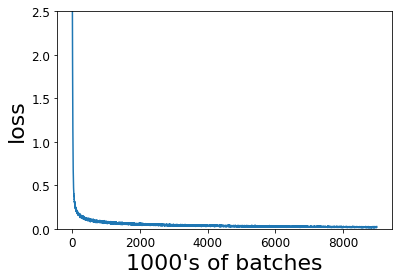

In [54]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

### Test loss and accuracy

This calculates the loss for each batch to find the total loss. If this number is significantly worse than the training data, it is a sign of overfitting. 

It also finds the accuracy by keeping track of the number of correct labels for each class of data to find each class's accuracy and the total accuracy. 

In [55]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1).cuda()
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

# set the module to evaluation mode
# used to turn off layers that are only useful for training
# like dropout and batch_norm
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1).cuda() / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for l, c in zip(labels.data, correct):
        class_correct[l] += c.item()
        class_total[l] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.cpu().numpy()[0]))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.018882

Test Accuracy of  zero: 99% (978/980)
Test Accuracy of   one: 99% (1133/1135)
Test Accuracy of   two: 99% (1028/1032)
Test Accuracy of three: 99% (1004/1010)
Test Accuracy of  four: 99% (979/982)
Test Accuracy of  five: 99% (887/892)
Test Accuracy of   six: 98% (945/958)
Test Accuracy of seven: 99% (1023/1028)
Test Accuracy of eight: 99% (969/974)
Test Accuracy of  nine: 98% (997/1009)

Test Accuracy (Overall): 99% (9943/10000)


### Visualize test data

This cell iterates over the test dataset, loading a random batch of image/label data, using `dataiter.next()`. It then uses the trained model to infer the predicted label, and plots the batch of images and predicted labels in a `batch_size/8 x 8` grid.

If the label is wrong, it is marked in red and the correct label is indicated in parentheses

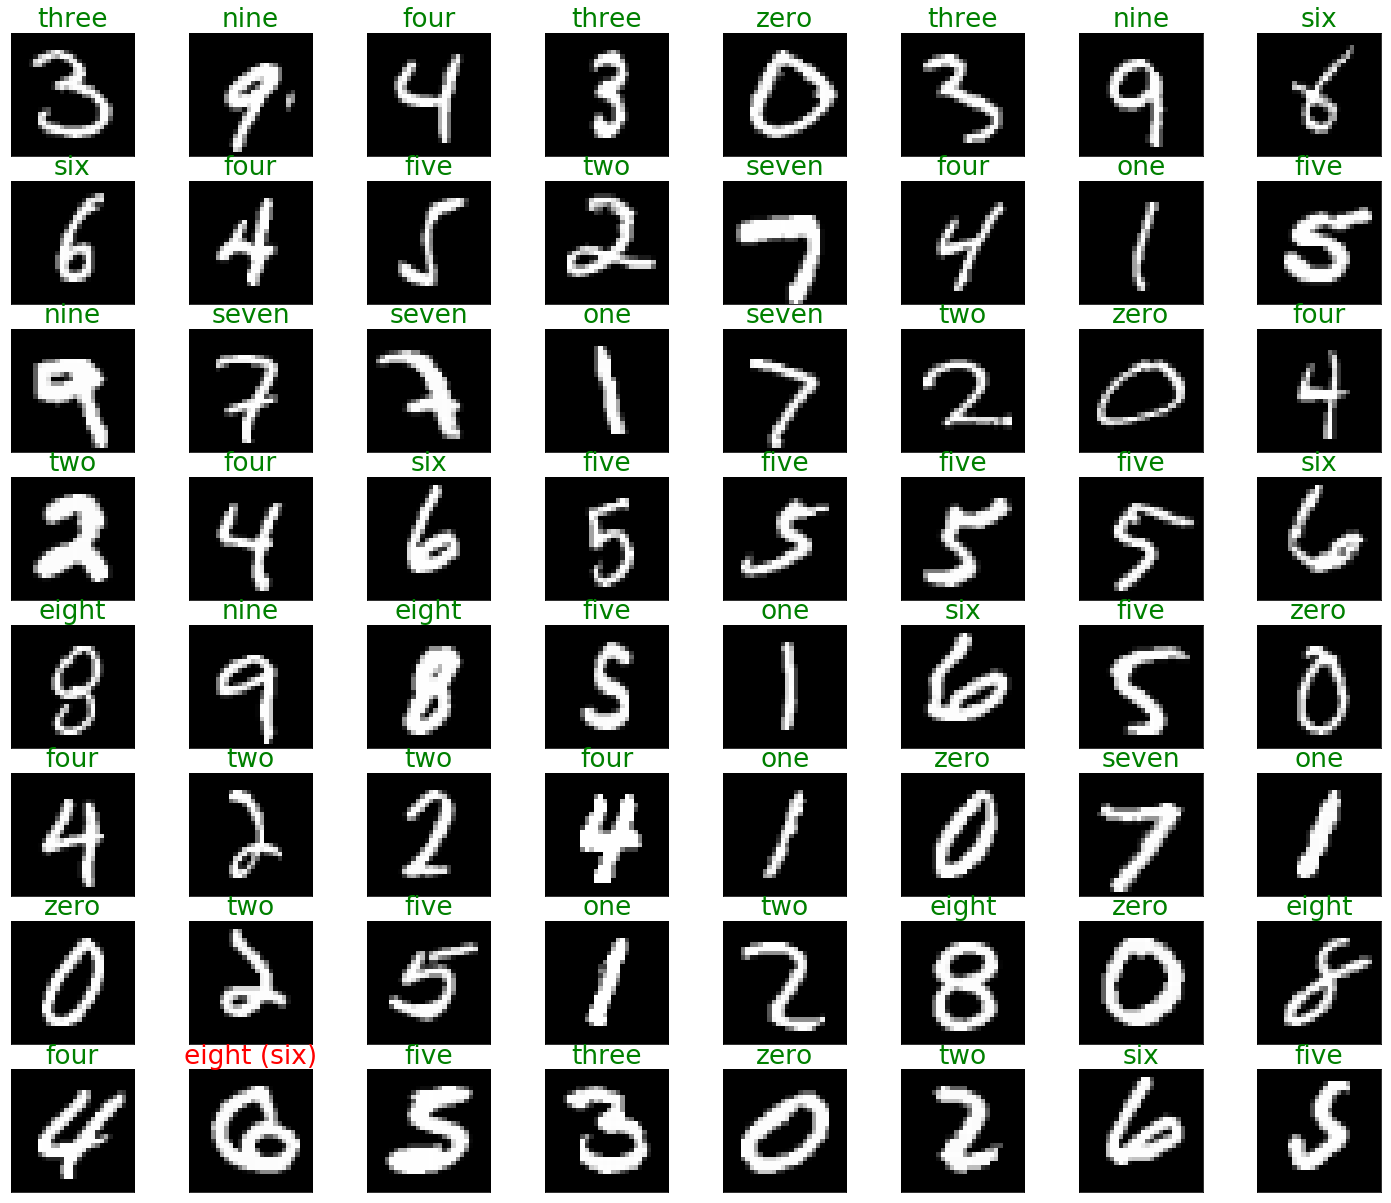

In [44]:
# Visualize Sample Results
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.cuda(), labels.cuda()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].cpu().numpy())
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, batch_size/3))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(batch_size/8, 8, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    if preds[idx]==labels[idx]:
        ax.set_title("{}".format(classes[preds[idx]], classes[labels[idx]]), color="green")
    else:
        ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]), color="red")

### Save the model

This cell saved the state of the model to a file that can be loaded in later. 

In [28]:
# Save state_dict
# Saving the model
model_dir = 'saved_models/'
model_name = 'Net2_100.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)